# <center><u>Credit Card Users Churn Prediction</u></center>

## Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import math
import time
import pandas as pd 
import numpy as np
import yellowbrick
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, preprocessing
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

***
***

## Loading the Dataset

In [2]:
churners = pd.read_csv("C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 6 - Featurization, Model Selection & Tuning (Week 20 to Week 22)/Project/BankChurners.csv")

In [3]:
churners.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School            NaN  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [4]:
print("There are", churners.shape[0], "rows and", churners.shape[1], "columns in the dataframe")

There are 10127 rows and 21 columns in the dataframe


***
***
## Information on Data

In [5]:
churners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

>We see all columns except *'Education_Level'* and '*Marital_Status*' have no null values. We'll be checking on these null values and will handle them with proper imputation methods

In [6]:
categorical_columns = churners.select_dtypes(include = ['object']).columns

In [7]:
# Getting unique counts for target variable, Attrition Flag
print(f"Unique Value counts for 'Attrition_Flag':")
print(churners['Attrition_Flag'].value_counts())
print("\n")

Unique Value counts for 'Attrition_Flag':
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64




In [8]:
# Checking summary on all numerical columns
churners.describe(include = ['int64', 'float64']).T

count          mean           std          min  \
CLIENTNUM                 10127.0  7.391776e+08  3.690378e+07  708082083.0   
Customer_Age              10127.0  4.632596e+01  8.016814e+00         26.0   
Dependent_count           10127.0  2.346203e+00  1.298908e+00          0.0   
Months_on_book            10127.0  3.592841e+01  7.986416e+00         13.0   
Total_Relationship_Count  10127.0  3.812580e+00  1.554408e+00          1.0   
Months_Inactive_12_mon    10127.0  2.341167e+00  1.010622e+00          0.0   
Contacts_Count_12_mon     10127.0  2.455317e+00  1.106225e+00          0.0   
Credit_Limit              10127.0  8.631954e+03  9.088777e+03       1438.3   
Total_Revolving_Bal       10127.0  1.162814e+03  8.149873e+02          0.0   
Avg_Open_To_Buy           10127.0  7.469140e+03  9.090685e+03          3.0   
Total_Amt_Chng_Q4_Q1      10127.0  7.599407e-01  2.192068e-01          0.0   
Total_Trans_Amt           10127.0  4.404086e+03  3.397129e+03        510.0   
Total_Trans_Ct            10127.0  6.485869e+01  2.347257e+01         10.0   
Total_Ct_Chng_Q4_Q1       10127.0  7.122224e-01  2.380861e-01          0.0   
Avg_Utilization_Ratio     10127.0  2.748936e-01  2.756915e-01          0.0   

                                   25%           50%           75%  \
CLIENTNUM                 7.130368e+08  7.179264e+08  7.731435e+08   
Customer_Age              4.100000e+01  4.600000e+01  5.200000e+01   
Dependent_count           1.000000e+00  2.000000e+00  3.000000e+00   
Months_on_book            3.100000e+01  3.600000e+01  4.000000e+01   
Total_Relationship_Count  3.000000e+00  4.000000e+00  5.000000e+00   
Months_Inactive_12_mon    2.000000e+00  2.000000e+00  3.000000e+00   
Contacts_Count_12_mon     2.000000e+00  2.000000e+00  3.000000e+00   
Credit_Limit              2.555000e+03  4.549000e+03  1.106750e+04   
Total_Revolving_Bal       3.590000e+02  1.276000e+03  1.784000e+03   
Avg_Open_To_Buy           1.324500e+03  3.474000e+03  9.859000e+03   
Total_Amt_Chng_Q4_Q1      6.310000e-01  7.360000e-01  8.590000e-01   
Total_Trans_Amt           2.155500e+03  3.899000e+03  4.741000e+03   
Total_Trans_Ct            4.500000e+01  6.700000e+01  8.100000e+01   
Total_Ct_Chng_Q4_Q1       5.820000e-01  7.020000e-01  8.180000e-01   
Avg_Utilization_Ratio     2.300000e-02  1.760000e-01  5.030000e-01   

                                   max  
CLIENTNUM                 8.283431e+08  
Customer_Age              7.300000e+01  
Dependent_count           5.000000e+00  
Months_on_book            5.600000e+01  
Total_Relationship_Count  6.000000e+00  
Months_Inactive_12_mon    6.000000e+00  
Contacts_Count_12_mon     6.000000e+00  
Credit_Limit              3.451600e+04  
Total_Revolving_Bal       2.517000e+03  
Avg_Open_To_Buy           3.451600e+04  
Total_Amt_Chng_Q4_Q1      3.397000e+00  
Total_Trans_Amt           1.848400e+04  
Total_Trans_Ct            1.390000e+02  
Total_Ct_Chng_Q4_Q1       3.714000e+00  
Avg_Utilization_Ratio     9.990000e-01

In [9]:
# Checking summary on all non-numerical columns
churners.describe(include = ["object"]).T

count unique                top  freq
Attrition_Flag   10127      2  Existing Customer  8500
Gender           10127      2                  F  5358
Education_Level   8608      6           Graduate  3128
Marital_Status    9378      3            Married  4687
Income_Category  10127      6     Less than $40K  3561
Card_Category    10127      4               Blue  9436

> With above information, we can see that:
>    * There are 10127 rows and 21 columns in our dataset which include 15 numerical and 6 non-numerical columns
>    * Two of the features have null values and would need imputation/correction for missing values
>    * The column "CLIENTNUM", representing unique client number for the customer holding the account is not required for data analysis and we can remove this column from our dataset
>    * The 'Attrition_Flag' feature, which is our target variable, is divided in 2 categories, _'Existing Customer'_ and *'Attrited Customer'*, and seems to be a target variable. However, there seems to be an imbalance in this with 8500 existing customers compared to 1627 attrited customers and would need sampling techniques to balance the data
>    * The most common card type is "Blue" with 9436 customers
>    * We also see that the column "Income_Category" has an unknown value 'abc' which doesn't match with the description defined for the column. We can handle this as well in future steps

In [10]:
churners.drop(columns=['CLIENTNUM']).duplicated().value_counts()

False    10127
Name: count, dtype: int64

>So we see there are no duplucates in the dataset. Let's proceed with next steps

In [11]:
# Dropping unique ID column 'CLIENTNUM' as that won't be used for analysis
churners.drop(['CLIENTNUM'], axis = 1, inplace = True)
churners.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3            NaN  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

> Now that we have dropped the unique attribute column, let's proceed with out exploratory data analysis

***
***
## Exploratory Data Analysis (EDA)

> Let's create a few functions for the easiness of execution

In [12]:
# Function for creating barplots with individual percentage for each category

def create_bar_plot(churners, figsize = (10,14), show_percent = True):
    """
    Barplot for respective columns

    churners: dataset
    feature: dataset column name
    figsize: size of figure (defaulted to (10,14))
    show_percent: shows pecentage of each category (default = true). Shows counts if false
    """
    
    n_rows = 3     # number of rows for the subplot grid
    n_columns = 2  # number of columns for the subplot grid
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize = figsize) # set the figure size
    axes = axes.flatten()
    
    # Plot countplots for each categorical feature
    for i, column in enumerate(categorical_columns):
        total = len(churners[column])  # length of the column
        axes[i] = sns.countplot(churners, x = column, palette = 'pastel', ax = axes[i])
        axes[i].tick_params(axis = 'x', rotation = 45)
        
        for p in axes[i].patches:
            if show_percent == True:
                label = "{:.1f}%".format(100 * p.get_height() / total) # shows percentage of each class of the category
            else:
                label = p.get_height()  # count of each level of the category

            x = p.get_x() + p.get_width() / 2 # width of the plot
            y = p.get_height()        # height of the plot
            axes[i].annotate(label, (x, y), ha = 'center', va = 'center', size = 12, xytext = (0, 5),
                        textcoords = "offset points") # annotate the percantage
    
    plt.tight_layout()
    plt.show() # show the plot
    

In [13]:
# Function for analysis of box plot and histogram combinations for respective columns

# Defining numerical columns
numerical_columns = churners.select_dtypes(include=['int64', 'float64']).columns

def histogram_boxplot_new(churners, figsize = (10,6), kde = True, bins = 10):
    """
    Boxplot and histogram combined

    churners: dataset
    feature: dataset column name
    figsize: size of figure (defaulted to (8,3))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (defaulted to 10)
    """
    
    n_rows = len(numerical_columns)  # number of rows for the subplot grid
    n_columns = 1  # number of columns for the subplot grid
    
    # setting the figure size
    fig, axes = plt.subplots(n_rows * 2, n_columns, figsize = (figsize[0], figsize[1] * n_rows * 2), 
                             gridspec_kw = {"height_ratios": [0.25, 0.75] * n_rows})
    axes = axes.flatten()
    
    for i, feature in enumerate(numerical_columns):
        ax_box = axes[2 * i]
        ax_hist = axes[2 * i + 1]
        
        #print(f"\nBox Plot and Histogram Combination of '{feature}' column")

        # creating boxplot with a dot indicating the mean value of the column
        sns.boxplot(data = churners, x = feature, ax = ax_box, showmeans = True, color = "green")

        # creating histogram
        sns.histplot(data = churners, x = feature, kde = kde, ax = ax_hist, bins = bins, color = "pink")

        ax_hist.axvline(churners[feature].mean(), color = "purple", linestyle = "--")  # Add mean (dotted line) to the histogram

        ax_hist.axvline(churners[feature].median(), color = "blue", linestyle = "-")  # Add median (a dot) to the histogram
        
        #plt.title(f"Histogram and Boxplot of '{feature}' column", fontsize = 12)
        
    plt.tight_layout()
    plt.show()  # to show the plot

In [14]:
# Function for analysis of box plot and histogram combinations for respective columns

def histogram_boxplot(churners, feature, figsize = (10,6), kde = True, bins = 10):
    """
    Boxplot and histogram combined

    churners: dataset
    feature: dataset column name
    figsize: size of figure (defaulted to (8,3))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (defaulted to 10)
    """
    f2, (ax_box, ax_hist) = plt.subplots(
        nrows = 2,  # Number of rows of the subplot grid = 2
        sharex = True,  # x-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize)  # creating the 2 subplots
    
    print(f"\nBox Plot and Histogram Combination of '{feature}' column")
    
    # creating boxplot with a dot indicating the mean value of the column
    sns.boxplot(data = churners, x = feature, ax = ax_box, showmeans = True, color = "green")  # boxplot will be created and a dot will indicate the mean value of the column
    
    # creating histogram
    sns.histplot(data = churners, x = feature, kde = kde, ax = ax_hist, bins = bins, color = "pink")
    
    ax_hist.axvline(churners[feature].mean(), color = "purple", linestyle = "--")  # Add mean to the histogram
    
    ax_hist.axvline(churners[feature].median(), color = "blue", linestyle = "-")  # Add median to the histogram

***
### UNIVARIATE ANALYSIS

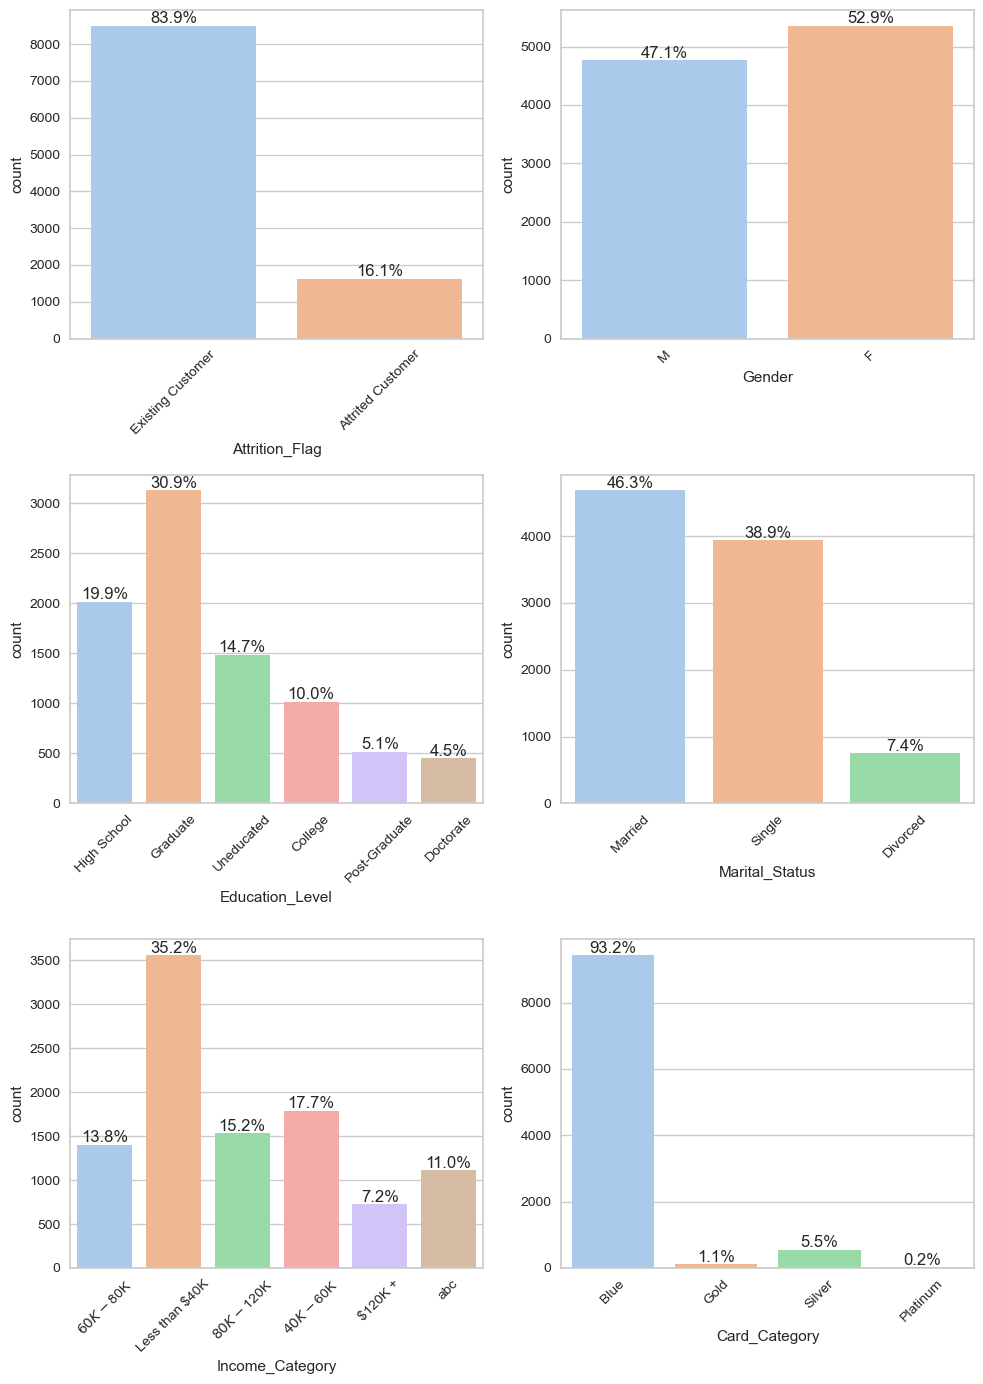

In [15]:
# Bar plot for various features
create_bar_plot(churners)

> With the above bar plot, we can see below points:
> 
>  1. **Attrition_Flag:**
>     * A majority of customers are 'Existing Customers' (83.9%), while 'Attrited Customers' make up only 16.1%
>     * This indicates that the bank retains a large portion of its customers, but a significant minority has left so it is crucial to analyze the reasons behind the 16.1% attrition to further reduce customer churn
>     <br><br>
>  2. **Gender:**
>      * The gender distribution is fairly balanced, with a slight majority of females (52.9%) compared to males (47.1%)
>      * This suggests that the bank's credit card services appeal to both males and females equally
>     <br><br>
>  3. **Education_Level:**
>      * The most common education level among customers is 'Graduate' (30.9%), followed by 'High School' (19.9%), 'Uneducated' (14.7%), and 'College' (10.0%)
>      * Fewer customers have 'Post-Graduate' (5.1%) and 'Doctorate' (4.5%) education levels
>      * This might indicate that the credit card products are more attractive to customers with higher education levels
>     <br><br>
>  4. **Marital_Status:**
>      * Most customers are 'Married' (46.3%), followed by 'Single' (38.9%), and a smaller portion are 'Divorced' (7.4%)
>      * This suggests that the bank's products might be particularly appealing to married individuals
>     <br><br>
>  5. **Income_Category:**
>      * The largest income category is 'Less than 40K' (35.2%), followed by '40K - 60K' (17.7%), '80K - 120K' (15.2%), '60K - 80K' (13.8%), and '120K +" (7.2%)
>      * There is also a category labeled 'abc' (11.0%), which should be treated as missing or incorrect data that need to be addressed
>     <br><br>
>  6. **Card_Category:**
>      * The overwhelming majority of customers have a 'Blue' card (93.2%), with a small number having 'Silver' (5.5%), 'Gold' (1.1%), and 'Platinum' (0.2%) cards
>      * This indicates that 'Blue' card is the most popular or possibly the entry-level card
>      * The bank may need to explore why other card categories are less popular and consider strategies to promote them


Box Plot and Histogram Combination of 'Customer_Age' column


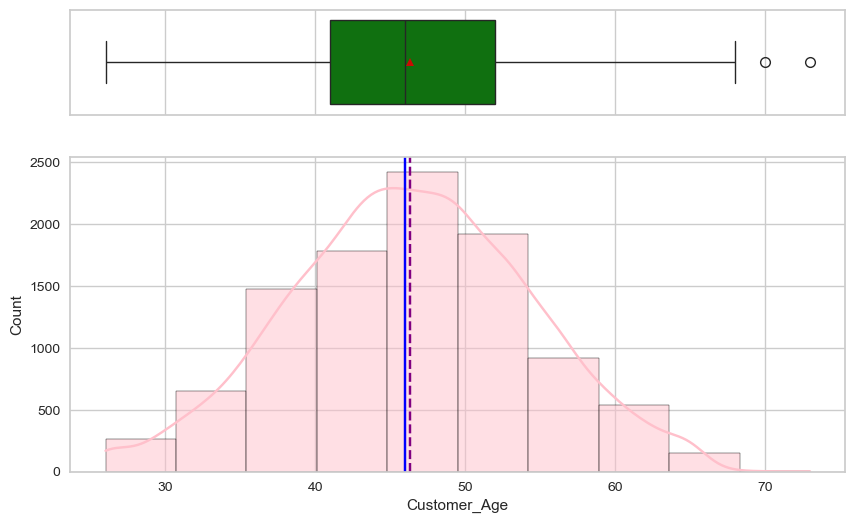

In [16]:
histogram_boxplot(churners, 'Customer_Age')

> * The age distribution seen from histogram is roughly normal and centers around 46 years which is same on the boxplot as well with it's IQR ranging from approximately 41 to 52 years
> * Though we see outliers but those are ignorable as we only see 2 of them at 70 and 73 years which can be true data. So no significant variation is seen with context to outliers
> * With above, we can see that the bank holds mostly middle-aged customer base. So the bank should cater more on leveraging products and services that cater to this age group. However, to divercify the age groups, bank should consider creating targetted campaigns to attract younger and older generations as well


Box Plot and Histogram Combination of 'Dependent_count' column


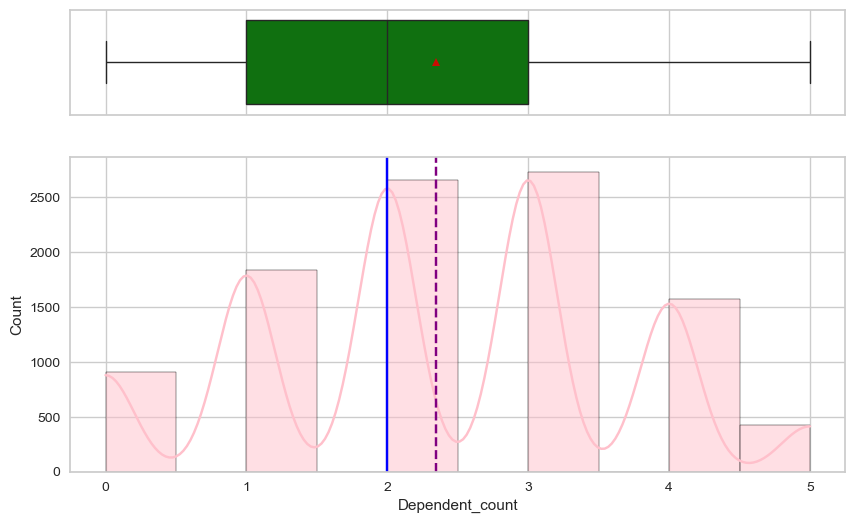

In [17]:
histogram_boxplot(churners, 'Dependent_count')

> * In the histogram, we see that the bank mostly has people with 2 dependents. The boxplot also gives a similar insight with the IQR ranging from 1 to 3
> * Since most customers have 1 to 3 dependents, bank seems to have a family oriented customer base. The bank should focus on developing family-oriented financial products and services to decrease the churn rate


Box Plot and Histogram Combination of 'Credit_Limit' column


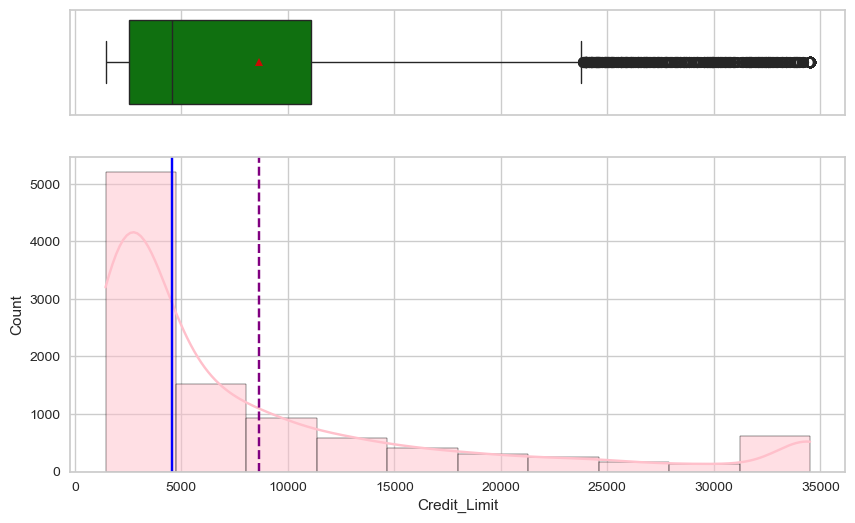

In [18]:
histogram_boxplot(churners, 'Credit_Limit')

> * The credit limit varies widely peaking on lower values and is right-skewed. With most common credit value 4500 dollars, there is a wider IQR and high valued outliers ranging till 34000 dollars
> * Since we see a lot of outliers in the data , this might indicate that the bank has high-valued customers
> * The bank can offer personalized services or rewards to high-value customers and consider periodic credit limit reviews and adjustments based on the credit behavior of lower credit limit customers
> * Though there are many outliers, all of these can't possibly be incorrect data and seem to be valid so we don't require outlier treatment in this case


Box Plot and Histogram Combination of 'Avg_Utilization_Ratio' column


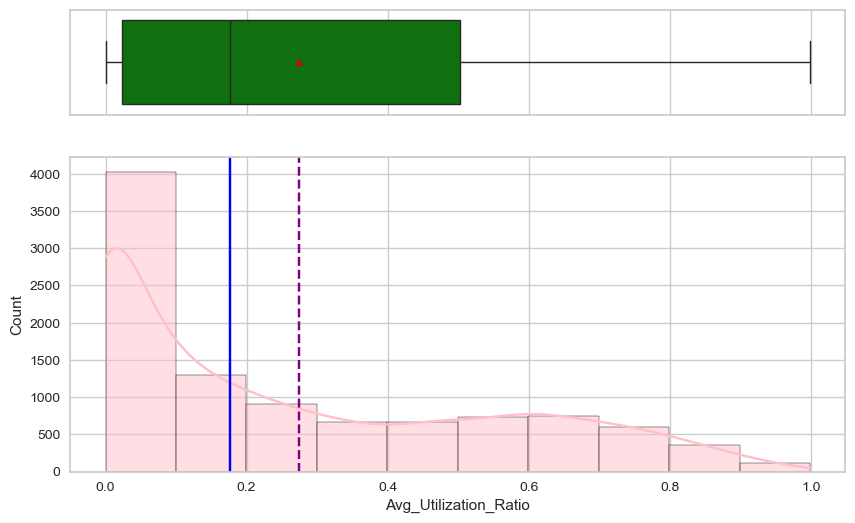

In [19]:
histogram_boxplot(churners, 'Avg_Utilization_Ratio')

>* Lesser average utilization ratio is common among customers with most common value around 0.18 and the IQR ranging from 0.02 to 0.5. It is right-skewed
>* Higher utilization ratios might indicate more finanical stress on customers. The bank should offer financial products that help customers manage their credit usage effectively

***
### BIVARIATE ANALYSIS

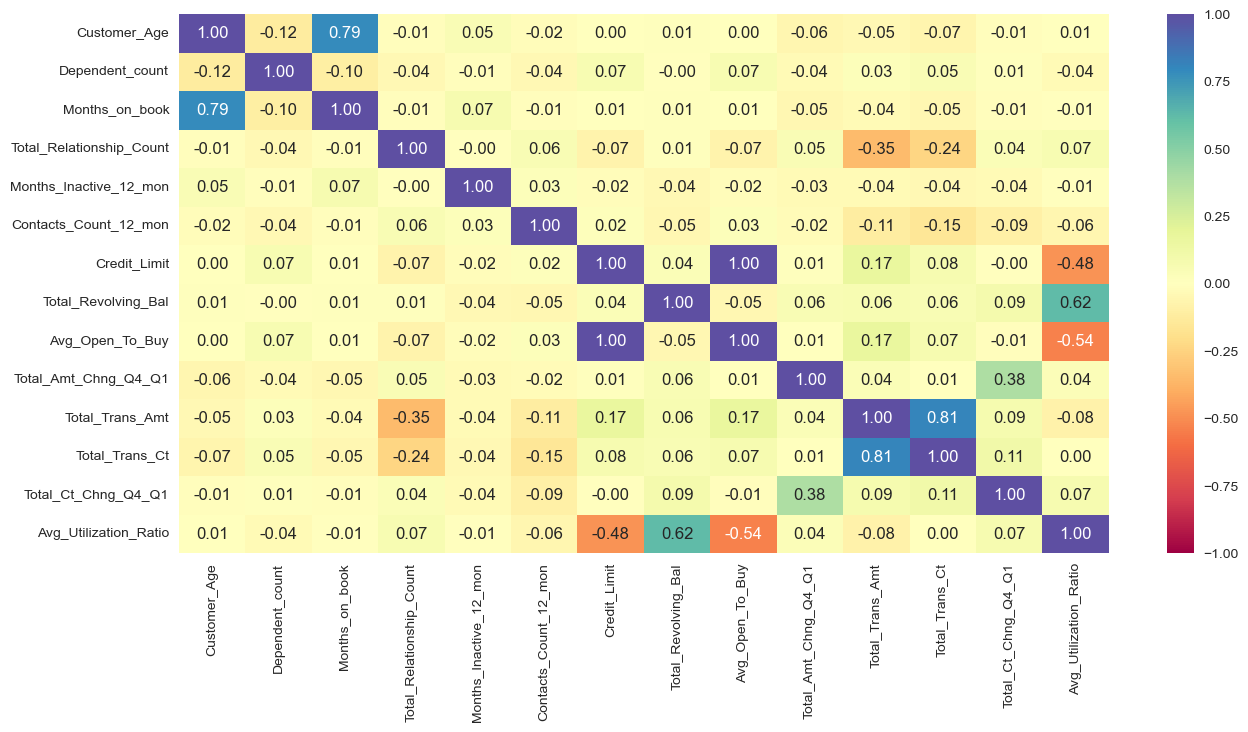

In [20]:
# Creating heatmap of all numerical variables

plt.figure(figsize = (15,7))
sns.heatmap(churners[numerical_columns].corr(), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")
plt.show()

>Seeing the heatmap, we can conclude that there are very few features which share a good correlation with each other
> * There is a strong positive correlation of 0.81 between 'Total_Trans_Amt' and 'Total_Trans_Ct' which shows that customers who make a higher number of transactions tend to have a higher total transaction amount
> * 'Months_on_book' and 'Customer_Age' also hold a strog positive correlation of 0.79 sugegsting that older customers tend to have been with the bank for a longer time. We can understand this further to design age specific customer retention strategies
> * With a positive correlation of 0.54, 'Avg_Open_To_Buy' and 'Credit_Limit' show that customers with higher credit limits tend to have more available credit
> * Higher utilization ratios are associated with lower available credit, which can be seen in the strong negative correlation of -0.54 between 'Avg_Utilization_Ratio' and 'Avg_Open_To_Buy'. This is logical because having available credit on the card after 12 months implies that the card might not have been used extensively during that time
> * 'Avg_Utilization_Ratio' and 'Credit_Limit' share a strong negative correlation of -0.48 where we can conclude that the customers with higher utilization ratios tend to have lower credit limits
> * There are several weak correlations which are close to 0, indicating little to no linear relationship between those variables

>Since 'Attrition_Flag' is going to be our target variable, let's invest a few steps to check the relationship of all features with Attrition_Flag

#### <u>Attrition Flag compared to other Numerical Features</u>

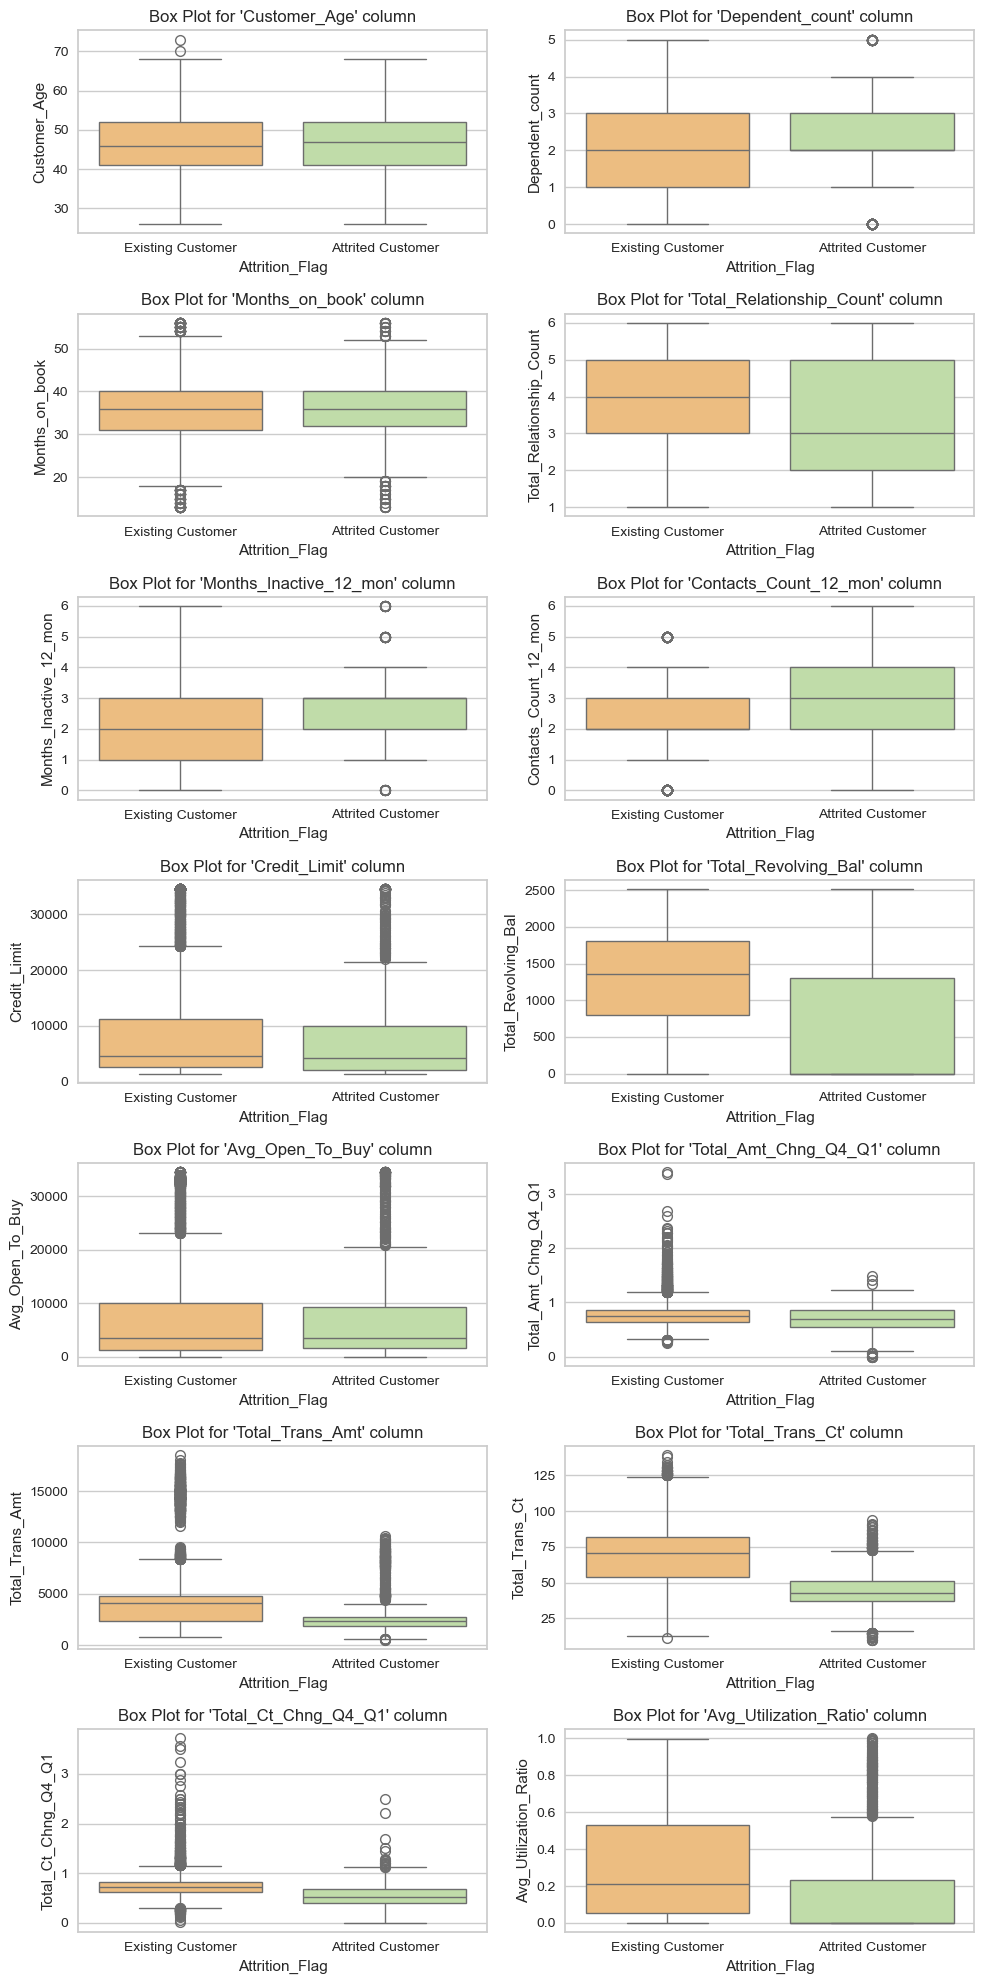

In [21]:
# Boxplots to check relationship between all numerical variables and Attrition_Flag

num_features = len(numerical_columns)
num_cols = 2  # Number of columns for the subplot grid
num_rows = math.ceil(num_features / num_cols)  # Number of rows needed

plt.figure(figsize=(10,20))

for i, feature in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(churners, x = 'Attrition_Flag', y = feature, palette = "Spectral")
    plt.title(f"Box Plot for '{feature}' column")
    plt.tight_layout()
plt.show()

> * The distribution of customer age is almost similar between existing and attrited customers. The bank can focus on reducing the retention rate on all age groups equally since age does not seem to significantly impact attrition rates
> * Attrited customers tend to have a slightly higher range of dependents compared to existing customers. The bank can consider offering family-oriented services or benefits to customers with more dependents to reduce churn rate
> * Attrited customers have a slightly longer average tenure with the company as seen on the box plot of 'Months_on_Book' so developing strategies to enhance loyalty programs for long-tenure customers might help in reducing the churn rate for customers
> * Customers who attrited were given slightly lower credit limits than existing customers. The bank would need to revisit its credit limit policies and offer high-valued limits to valued customers
> * Attrited customers have a higher average revolving balance than existing customes whereas the total transaction amount and count is seen to be higher with existing cutomers. The bank can promote transaction based rewards for such customers

#### <u>Attrition Flag compared to other Categorical Features</u>

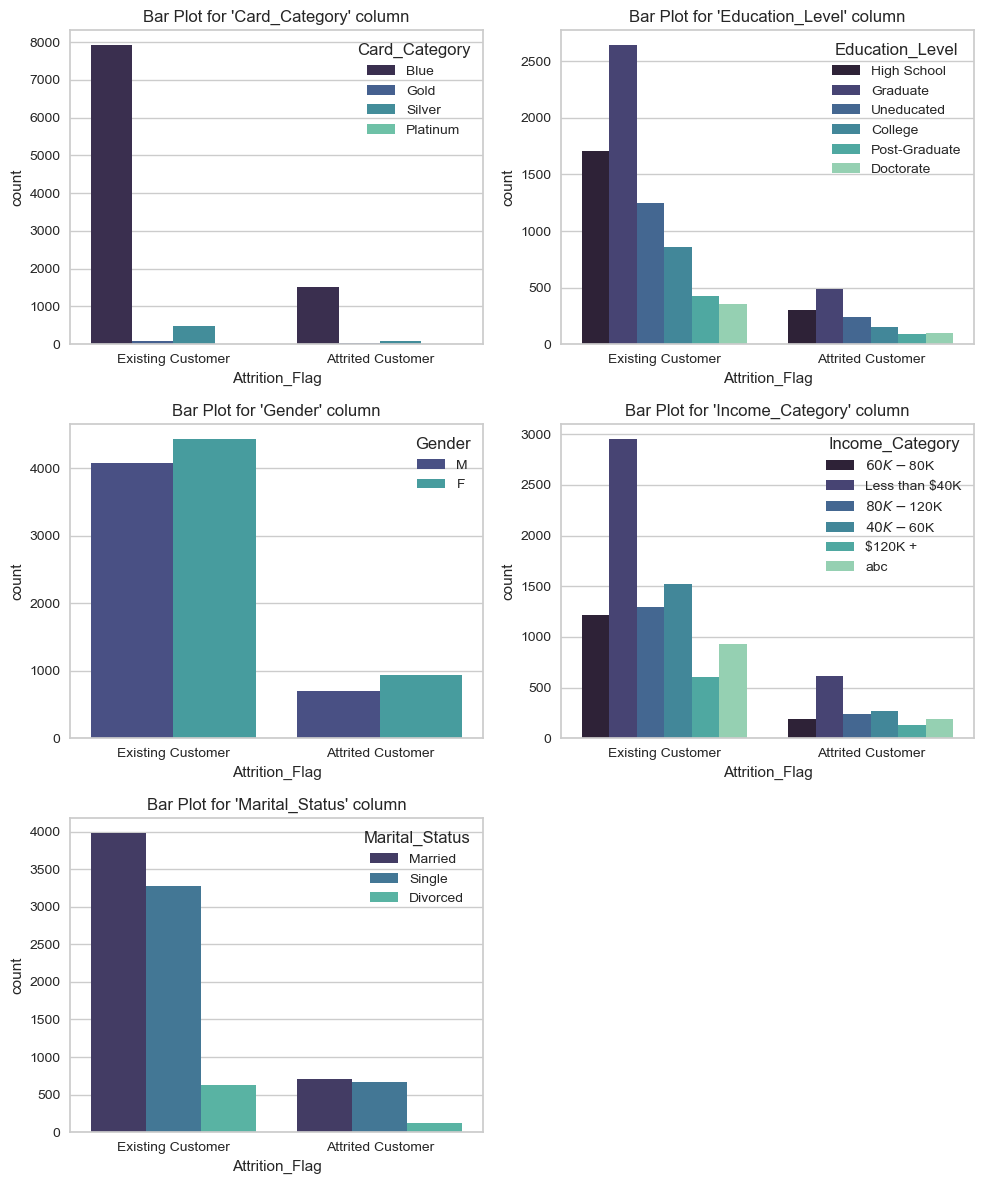

In [22]:
# BarPlot to check relationship between all categorical variables and Attrition_Flag

num_features = len(categorical_columns.difference(['Attrition_Flag'])) # removing Attrition_Flag feature from list of categorical columns
num_cols = 2  # Number of columns for the subplot grid
num_rows = math.ceil(num_features / num_cols)  # Number of rows needed

plt.figure(figsize = (10, 12))

for i, feature in enumerate(categorical_columns.difference(['Attrition_Flag'])):
    plt.subplot(num_rows, num_cols, i+1)
    sns.countplot(churners, x = "Attrition_Flag",hue = feature, palette = "mako")
    plt.tight_layout()
    plt.title(f"Bar Plot for '{feature}' column")
plt.show()

> 1. **_Card Category_:**
>     * The majority of existing customers hold a Blue card, followed by fewer customers holding Gold, Silver, and Platinum card
>     * Attrited Customers also have dominance in Blue Card as compared to other category of cards
>     * Bank must focus more on providing maximum benefits to Blue card holders as they hold majority of the section however should also improve offers on other cards to increase their proportions
> <br><br>
> 2. **_Education Level_:**
>     * Most existing customers are either Graduates or have attended High School and similar pattern is also observed with Attrited Customers as well. So we don't see any major changes here
>     * Bank can offer educational benefits to customers and can tailor financial planning workshops as well
> <br><br>
> 3. **_Gender_:**
>     * The distribution is relatively balanced between attrited and existing customers from gender perspective with a slight inclination towards females
>     * The bank can launch in more women centric offers to reduce attrition rate for females
> <br><br>
> 4. **_Income Category_:**
>     * This distribution is also similar with both categories of customers and mostly falls into the 60K–80K and <40K income categories where attrition is more in such case
>     * Since this is the middle clas bracket, bank can launch more offers for such customers to reduce the churn rate
> <br><br>
> 5. **_Marital Status_:**
>     * Most existing customers are Married, followed by Single and Divorced
>     * The attrition rate is higher among Married customers
>     * The bank must consider providing family-oriented benefits to retain married customers who are at higher risk of attrition

***
### MULTIVARIATE ANALYSIS

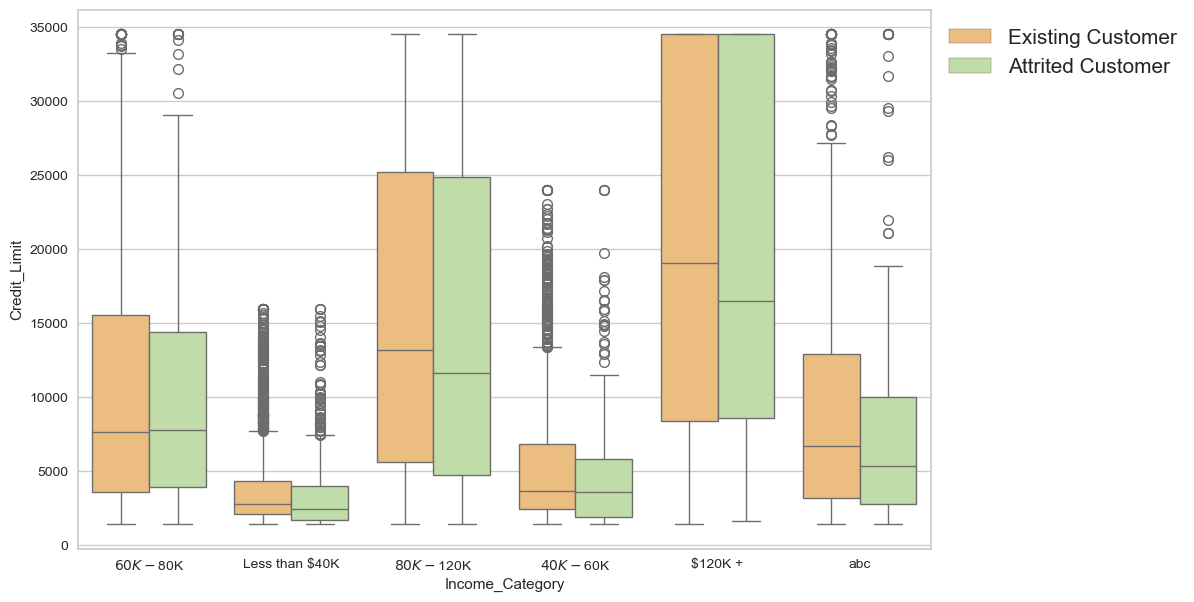

In [23]:
# Analysis with Violin Plot

plt.figure(figsize = (11,7)) # Adjust_size
sns.boxplot(churners, x = 'Income_Category', y = 'Credit_Limit', hue = 'Attrition_Flag', palette = 'Spectral')
plt.legend(bbox_to_anchor = (1, 1), fontsize = 15)
plt.show() #display_plot

> * Customers in the 120K+ income category generally have the highest credit limits with equal ratio od existing and attrited customers. The bank can maintain high credit limits for high-income customers as it seems to correlate with lower attrition rates
> * Customers in the "Less than 40K" income category generally have the lowest credit limits. Bank might want to give special offers to for low-income customers to retain them
> * For customers in the "60K – 80K" and "80K – 120K" income categories, the credit limits are relatively high. The bank might give benefits to enhance their experience and loyalty
> * There is a 5th category, "abc", which seems to be an error with customer data. These might need to be revisited by the bank however, we can impute them accordingly for our ease
> * With 'Credit_Limit' having a lot of outliers, it is higlighted in this plot as well. However, as seen earlier, these seem to be valid outliers

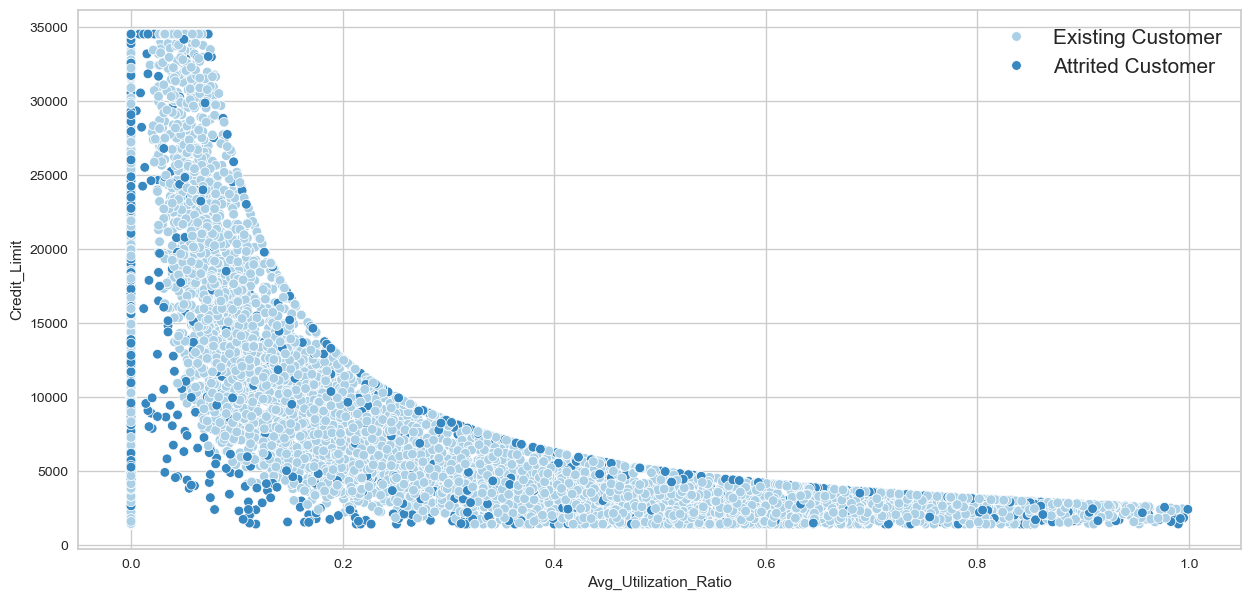

In [24]:
# Scatter Plot for Avg_Utilization_Ratio and Credit_Limit 
plt.figure(figsize = (15,7)) #Adjust size
sns.scatterplot(churners, x = "Avg_Utilization_Ratio", y = "Credit_Limit", hue = "Attrition_Flag", palette = "Blues")
plt.legend(bbox_to_anchor = (1, 1), fontsize = 15)
plt.show()#Display plot 

>From this, we see that:
> * Customers with high utilization ratios and low credit limits are more likely to be at risk of attrition. This also shows an inverse relationship between credit limit and utilization ratio
> * A significant number of customers have a utilization ratio of 0.0 across all credit limits. The bank should further take measures to increase engagement as this might be under-utilization of bank products

***
***
## Data Preprocessing

***
### Missing and Incorrect Value Treatment

> Before proceeding with further steps, let's check on the number of null values as well as unique values for all of our categorical columns

In [25]:
churners.isna().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [26]:
# Getting unique counts for categorical column

for column in categorical_columns:
    print(f"Unique Value counts for column '{column}':")
    print(churners[column].value_counts())
    print("\n")

Unique Value counts for column 'Attrition_Flag':
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64


Unique Value counts for column 'Gender':
Gender
F    5358
M    4769
Name: count, dtype: int64


Unique Value counts for column 'Education_Level':
Education_Level
Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64


Unique Value counts for column 'Marital_Status':
Marital_Status
Married     4687
Single      3943
Divorced     748
Name: count, dtype: int64


Unique Value counts for column 'Income_Category':
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: count, dtype: int64


Unique Value counts for column 'Card_Category':
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64




> Now that we have all unique values for each category and columns with null values, let proceed with data correction / imputation / encoding / etc

> We see that there is a larger set which either has anonymous value ("abc") in 'Income_Category' column or has null values in 'Education_Level' and 'Marital_Status' columns. 
> <br>We would go with relacing such values with 'Unknown' value as imputing with mode might introduce a bias , particularly when the mode is very dominant (e.g., with around 3100 values with 'Graduate' in Education_Level, imputing with mode, i.e., Graduate will make the column bias towards Garduate category and have imbalance of data)<br>
>Replacing missing or incorrect values with 'Unknown' will provide a clarity that those values were originally missing or mislabeled and it will preserve the integrity of the original data

#### <u>Income Category - Anonymous Value Treatment</u>

> We see that we have a different category with the name "abc" which has a significant amount of data. We can't remove the corresponding rows so we'll keep the rows and impute these anonymous values with "Unknown" as the value

In [27]:
churners['Income_Category'] = churners['Income_Category'].replace('abc', 'Unknown')
churners['Income_Category'].value_counts()

Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64

#### <u>Education Level - Null Value Treatment

In [28]:
churners['Education_Level'].isna().value_counts()

Education_Level
False    8608
True     1519
Name: count, dtype: int64

In [29]:
churners['Education_Level'].fillna('Unknown', inplace = True)
churners.sample(5)

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
7488  Existing Customer            33      F                2       Doctorate   
2244  Existing Customer            42      M                4         College   
397   Existing Customer            43      M                3         College   
3836  Existing Customer            50      M                1      Uneducated   
2541  Existing Customer            48      M                3        Graduate   

     Marital_Status Income_Category Card_Category  Months_on_book  \
7488            NaN         Unknown          Blue              21   
2244            NaN     $60K - $80K          Blue              25   
397             NaN    $80K - $120K          Blue              39   
3836        Married     $40K - $60K          Blue              36   
2541        Married     $60K - $80K          Gold              37   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
7488                         3                       3                      3   
2244                         4                       3                      3   
397                          3                       3                      1   
3836                         5                       1                      4   
2541                         5                       1                      2   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
7488        4651.0                 2499           2152.0   
2244        3092.0                 1115           1977.0   
397        24850.0                 1662          23188.0   
3836        2071.0                 1035           1036.0   
2541       34516.0                 2429          32087.0   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
7488                 0.766             5097              79   
2244                 0.802             2133              41   
397                  0.693             1226              25   
3836                 0.754             4092              74   
2541                 0.742             3205              57   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
7488                0.795                  0.537  
2244                0.783                  0.361  
397                 0.923                  0.067  
3836                0.947                  0.500  
2541                0.727                  0.070

#### <u>Marital Status - Null Value Tratment

In [30]:
churners['Marital_Status'].isna().value_counts()

Marital_Status
False    9378
True      749
Name: count, dtype: int64

In [31]:
churners['Marital_Status'].fillna('Unknown', inplace = True)
churners.sample(5)

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
9512  Existing Customer            42      M                4        Graduate   
6648  Existing Customer            55      M                3        Graduate   
7737  Attrited Customer            44      F                4     High School   
1634  Attrited Customer            26      F                0     High School   
8376  Existing Customer            45      F                4      Uneducated   

     Marital_Status Income_Category Card_Category  Months_on_book  \
9512         Single     $40K - $60K          Blue              36   
6648         Single         $120K +          Blue              42   
7737        Unknown  Less than $40K          Blue              38   
1634         Single     $40K - $60K          Blue              13   
8376         Single     $40K - $60K          Blue              36   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
9512                         1                       1                      2   
6648                         3                       3                      2   
7737                         2                       2                      3   
1634                         2                       2                      4   
8376                         1                       1                      3   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
9512        6128.0                 2239           3889.0   
6648       31636.0                 2517          29119.0   
7737        2616.0                 2505            111.0   
1634        1730.0                 1616            114.0   
8376        3918.0                 2070           1848.0   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
9512                 0.768            13505             116   
6648                 0.718             4231              68   
7737                 0.828             2576              42   
1634                 0.331              869              27   
8376                 0.760             4700              69   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
9512                0.681                  0.365  
6648                1.061                  0.080  
7737                0.500                  0.958  
1634                0.286                  0.934  
8376                0.643                  0.528

> Now that all null and incorrevct values are covered, lets proceed with encoding our data to ease the further process.<br><br>
>To encode the categorical features in the given dataframe, we can go with below approaches:
> 1. **Label Encoding -** This approach is best suited for ordinal columns however, since we do not have any ordinal columns in our current dataset, let's see the next approaches<br><br>
> 2. **One-Hot Encoding -** We can perform this on all of the categorical columns as all columns do not have any inherent order and one-hot encoding will treat each category independently here. Hoever, it will introduce new columns as well and make our dataset larger. Let's check on next approach<br><br>
> 3. **Manual Encoding -** This feels to be a better approach for categorical variables here as we have less unique values for each categorical data so it will be easy to implement. Also, we will handle less number of columns compared to one-hot encoding and will be easier to handle data as well
 >
>*Seeing above options, we'll conclude to go with manual encoding for all the columns*
 >
>Let's move ahead with the code.

In [32]:
# Manual Encoding

churners['Attrition_Flag'].replace(['Existing Customer', 'Attrited Customer'], 
                                  [0, 1], inplace = True)
churners['Gender'].replace(['M', 'F'], 
                          [0, 1], inplace = True)
churners['Education_Level'].replace(['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 
                                    'Post-Graduate', 'Doctorate'], 
                                   [0, 1, 2, 3, 4, 5, 6], inplace = True)
churners['Marital_Status'].replace(['Unknown', 'Single', 'Married', 'Divorced'],
                                  [0, 1, 2, 3], inplace = True)
churners['Income_Category'].replace(['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'], 
                                   [0, 1, 2, 3, 4, 5], inplace = True)
churners['Card_Category'].replace(['Blue', 'Silver', 'Gold', 'Platinum'], 
                                  [0, 1, 2, 3], inplace = True)

print("\nManually Encoded DataFrame:")
churners.sample(10, random_state = 42)


Manually Encoded DataFrame:


Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
3781               0            48       1                3                1   
2922               0            59       0                1                1   
5070               0            37       1                2                4   
7246               0            47       0                3                6   
623                0            42       0                3                0   
3931               0            65       0                1                4   
4767               0            52       1                3                0   
7094               0            58       1                2                2   
3282               0            35       0                1                6   
3994               1            48       0                4                3   

      Marital_Status  Income_Category  Card_Category  Months_on_book  \
3781               1                1              0              39   
2922               1                1              0              53   
5070               3                1              0              36   
7246               3                2              0              36   
623                1                4              0              33   
3931               1                1              0              56   
4767               1                0              0              36   
7094               3                0              2              36   
3282               1                2              0              24   
3994               2                4              0              32   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
3781                         4                       3                      4   
2922                         5                       5                      4   
5070                         4                       3                      3   
7246                         4                       2                      3   
623                          3                       3                      2   
3931                         5                       3                      2   
4767                         3                       1                      2   
7094                         5                       4                      3   
3282                         6                       3                      2   
3994                         5                       2                      3   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
3781        2991.0                 1508           1483.0   
2922        2192.0                 1569            623.0   
5070        1734.0                  987            747.0   
7246        4786.0                 1516           3270.0   
623         3714.0                 2170           1544.0   
3931        7636.0                    0           7636.0   
4767       10273.0                 1657           8616.0   
7094       34516.0                 1864          32652.0   
3282       10467.0                 1961           8506.0   
3994       25190.0                    0          25190.0   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
3781                 0.703             3734              64   
2922                 0.706             4010              79   
5070                 0.879             4727              67   
7246                 0.940             4973              74   
623                  0.524             1454              35   
3931                 0.801             3880              67   
4767                 0.710             3778              70   
7094                 0.664             3595              52   
3282                 0.713             2665              65   
3994                 0.467             1533              41   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
3781                0.882         

***
### Outlier Detection and Treatment - Placeholder

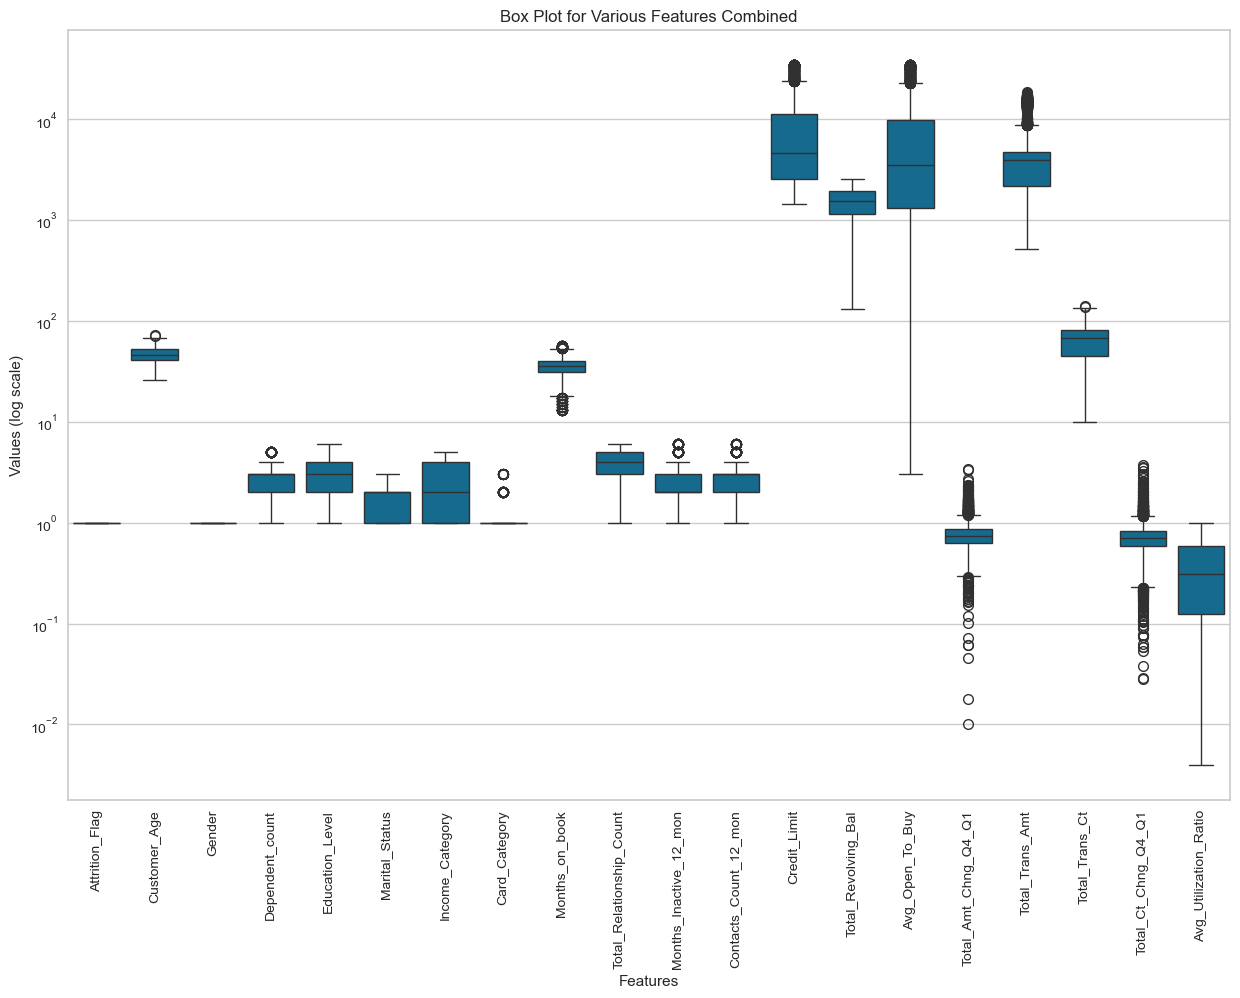

In [33]:
# Box Plot for all features combined

# Melt the DataFrame into long format
melted = churners.melt(var_name='Feature', value_name='Value')

# Filter out non-positive values to avoid issues with log scale
melted = melted[melted['Value'] > 0]

# Create the box plot
plt.figure(figsize=(15,10))
sns.boxplot(x='Feature', y='Value', data=melted)
plt.title("Box Plot for Various Features Combined")
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel("Values (log scale)")
plt.xlabel("Features")
plt.show()

> With the above box plot we see there are many columns which have outliers in them. Let's try to find out the number of outliers as well

In [34]:
# Redefining numerical columns
numerical_columns = churners.select_dtypes(include=['int64', 'float64']).columns

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

columns_with_outliers = []
outlier_df = pd.DataFrame()  # Initialize an empty DataFrame to hold outlier rows
print(f'Number of outliers in: \n')
for col in numerical_columns.difference(['Attrition_Flag']):
    outliers = detect_outliers_iqr(churners, col)
    if(len(outliers) > 5):
        outlier_df = pd.concat([outlier_df, outliers])  # Append outlier rows
        columns_with_outliers.append(col)
    print(f'    {col}: {len(outliers)}')

outlier_df = outlier_df.drop_duplicates()  # Remove duplicate rows
print("\nUnique rows with outliers:", outlier_df.shape[0])

Number of outliers in: 

    Avg_Open_To_Buy: 963
    Avg_Utilization_Ratio: 0
    Card_Category: 691
    Contacts_Count_12_mon: 629
    Credit_Limit: 984
    Customer_Age: 2
    Dependent_count: 0
    Education_Level: 0
    Gender: 0
    Income_Category: 0
    Marital_Status: 0
    Months_Inactive_12_mon: 331
    Months_on_book: 386
    Total_Amt_Chng_Q4_Q1: 396
    Total_Ct_Chng_Q4_Q1: 394
    Total_Relationship_Count: 0
    Total_Revolving_Bal: 0
    Total_Trans_Amt: 896
    Total_Trans_Ct: 2

Unique rows with outliers: 3482


> As we see, there are around 3500 unique rows with outliers, let's try to treat them with Log Transformation as models trained on log-transformed data are often more robust to outliers and provide better predictions.

In [35]:
outlier_df_after_transform = pd.DataFrame()  # Initialize an empty DataFrame to hold outlier rows
total_outliers_before = 0
total_outliers_after = 0

print(f'Number of outliers in:')
for column in columns_with_outliers:
    print(f'\n  {column}:')
    print(f'    Before Log Transformation: {len(detect_outliers_iqr(churners, column))}')
    
    
    total_outliers_before += len(detect_outliers_iqr(churners, column))
    churners[column] = np.log1p(churners[column])
    # churners = apply_quantile_transform(churners,column)
    # churners[column] = apply_boxcox(churners[column]) # Apply Box-Cox transformation to each numerical column
    
    print(f'    After Log Transformation: {len(detect_outliers_iqr(churners, column))}')
    
    outliers_after_transform = detect_outliers_iqr(churners, column)
    total_outliers_after += len(outliers_after_transform)
    
    if(len(outliers_after_transform) > 5):
        outlier_df_after_transform = pd.concat([outlier_df_after_transform, outliers_after_transform])  # Append outlier rows

outlier_df_after_transform = outlier_df_after_transform.drop_duplicates()  # Remove duplicate rows
print("\nUnique rows with outliers:", outlier_df_after_transform.shape[0])
    
print("\nTotal Outliers: \n    Before Log Transformation -", total_outliers_before)
print("    After Log Transformation -", total_outliers_after)

Number of outliers in:

  Avg_Open_To_Buy:
    Before Log Transformation: 963
    After Log Transformation: 21

  Card_Category:
    Before Log Transformation: 691
    After Log Transformation: 691

  Contacts_Count_12_mon:
    Before Log Transformation: 629
    After Log Transformation: 453

  Credit_Limit:
    Before Log Transformation: 984
    After Log Transformation: 0

  Months_Inactive_12_mon:
    Before Log Transformation: 331
    After Log Transformation: 153

  Months_on_book:
    Before Log Transformation: 386
    After Log Transformation: 466

  Total_Amt_Chng_Q4_Q1:
    Before Log Transformation: 396
    After Log Transformation: 378

  Total_Ct_Chng_Q4_Q1:
    Before Log Transformation: 394
    After Log Transformation: 419

  Total_Trans_Amt:
    Before Log Transformation: 896
    After Log Transformation: 191

Unique rows with outliers: 2748

Total Outliers: 
    Before Log Transformation - 5670
    After Log Transformation - 2772


> Now that our columns are treated with Log Transformation, we see that the number of unique rows with outliers has now reduced to 2748. We also se the total number of outliers reduced to half now. 
><br>Though we see some columns not having effective reduction in the number of outliers, those seem to be valid. For example, under 'Card_Category' Feature, there are 4 types of cards for customers to chose. Now less number of people option for a specific card doesn't make that type an outlier. So we'll proceed with this transformed data for carrying forward our analysis

> Let's plot the box plot for transformed data now

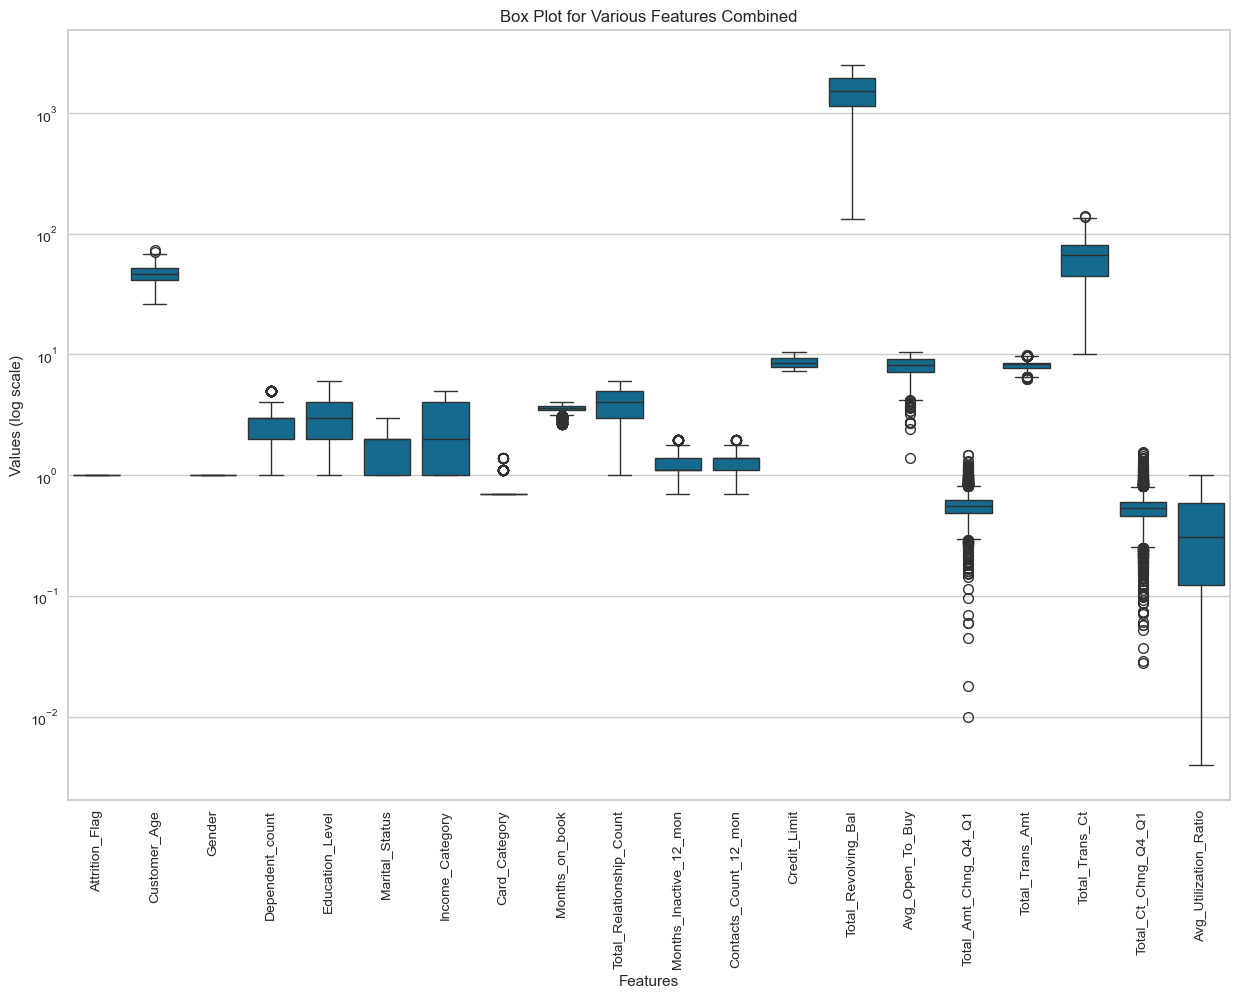

In [36]:
# Box Plot for all features combined

# Melt the DataFrame into long format
melted = churners.melt(var_name='Feature', value_name='Value')

# Filter out non-positive values to avoid issues with log scale
melted = melted[melted['Value'] > 0]

# Create the box plot
plt.figure(figsize=(15,10))
sns.boxplot(x='Feature', y='Value', data=melted)
plt.title("Box Plot for Various Features Combined")
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel("Values (log scale)")
plt.xlabel("Features")
plt.show()

> With the above box plot and data we can see that though there are many outliers for some of our columns, these seem to be valid and a majority of outliers have already been treated. Let's proceed with our further analysis and steps

***
### Feature Engineering

> Although we have enough features with us, let's introduce new columns to our dataset.
> 
> **'Loyalty_Score'** column to calculate the loyalty scores of the customer<br>
> **'Loyalty_Indicator'** column to showcase if the customer has been loyal to the bank for past years or not based on their loyalty scores
> This depends on multiple factors such as:
>  * <u>How long the customer has been with the company?</u> - We can check this from the 'Months_on_Books' columns, Longer tenure can indicate loyalty
>  * <u>How much products and services the customer uses?</u> - More products or services the customer uses, higher the loyalty. We can get this data from 'Total_Relationship_Count' column
>  * <u>Transaction history of the customer?</u> - Which we can get from 'Total_Trans_Amt' and 'Total_Trans_Ct' columns. Consistent use within a certain range might be a good indicator of loyalty
> 
> To get the loyalty scores, we can start with scaling these 4 columns and then having an equal weightage of each column for calculation.
> <br><br>
> Once we have the Loyalty Scores, any customer having their Loyalty Score more than the average value of the column can be considered as a Loyal customer. We can put a '1' for yes indicating Loyalty and '0' for No indicating more attaention to these set of customer which are more likely to churn. With introduction of this column, Bank will be able to reward its customers with offers of interest and reduce their churning

> Another important point to add here is to introduce scaling for these columns. This is done because different features have different scales (e.g., Total_Trans_Amt is in the thousands, while Months_on_book is in the tens) and to combine them meaningfully, they need to be on a comparable scale.<br><br>
> For this we'll be using RobustScaler, as our dataframe has many outliers and RobustScaler is robust to outliers. We can also use StandardScaler as it is also less sensitive to outlier, however, RobustScaler outweights StandardScaler and will provide a more balanced scaling.<br><br>
> **NOTE -** We'll be performing scaling temporarily and not fully on all values, yet.

In [37]:
columns_to_calculate_loyalty = ['Months_on_book', 'Total_Relationship_Count', 'Total_Trans_Amt', 'Total_Trans_Ct']

# Initializing Standard Scaler
scaler_for_loyalty_calculation = RobustScaler()

# Fitting the scaler on the data
scaler_for_loyalty_calculation.fit(churners[columns_to_calculate_loyalty])

# Transforming the data in columns without affecting the original dataframe
scaled_features = scaler_for_loyalty_calculation.transform(churners[columns_to_calculate_loyalty])

# Calculating a composite loyalty score using the scaled features from above
loyalty_score = (scaled_features[:, 0] * 0.25 +  # Months_on_book
                 scaled_features[:, 1] * 0.25 +  # Total_Relationship_Count
                 scaled_features[:, 2] * 0.25 +  # Total_Trans_Amt
                 scaled_features[:, 3] * 0.25)   # Total_Trans_Ct

# Adding the Loyalty_Score column to the original dataframe without actually scaling the original features yet
churners['Loyalty_Score'] = loyalty_score.round(3)

# Defining the thresholds for loyalty
threshold_for_customer_loyalty = churners['Loyalty_Score'].mean()  # calculating the mean of Loyalty_Score' column
churners['Loyalty_Indicator'] = np.where(churners['Loyalty_Score'] > threshold_for_customer_loyalty, 1, 0)



In [38]:
#churners['Loyalty_Indicator'] = churners['Months_on_book'].apply(lambda x: 1 if x > 36 else 0)
churners.sample(10, random_state = 42)

Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
3781               0            48       1                3                1   
2922               0            59       0                1                1   
5070               0            37       1                2                4   
7246               0            47       0                3                6   
623                0            42       0                3                0   
3931               0            65       0                1                4   
4767               0            52       1                3                0   
7094               0            58       1                2                2   
3282               0            35       0                1                6   
3994               1            48       0                4                3   

      Marital_Status  Income_Category  Card_Category  Months_on_book  \
3781               1                1       0.000000        3.688879   
2922               1                1       0.000000        3.988984   
5070               3                1       0.000000        3.610918   
7246               3                2       0.000000        3.610918   
623                1                4       0.000000        3.526361   
3931               1                1       0.000000        4.043051   
4767               1                0       0.000000        3.610918   
7094               3                0       1.098612        3.610918   
3282               1                2       0.000000        3.218876   
3994               2                4       0.000000        3.496508   

      Total_Relationship_Count  ...  Credit_Limit  Total_Revolving_Bal  \
3781                         4  ...      8.003697                 1508   
2922                         5  ...      7.693026                 1569   
5070                         4  ...      7.458763                  987   
7246                         4  ...      8.473659                 1516   
623                          3  ...      8.220134                 2170   
3931                         5  ...      8.940760                    0   
4767                         3  ...      9.237372                 1657   
7094                         5  ...     10.449207                 1864   
3282                         6  ...      9.256078                 1961   
3994                         5  ...     10.134242                    0   

      Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
3781         7.302496              0.532391         8.225503              64   
2922         6.436150              0.534151         8.296796              79   
5070         6.617403              0.630740         8.461258              67   
7246         8.092851              0.662688         8.511980              74   
623          7.342779              0.421338         7.282761              35   
3931         8.940760              0.588342         8.263848              67   
4767         9.061492              0.536493         8.237215              70   
7094        10.393692              0.509224         8.187577              52   
3282         9.048645              0.538246         7.888335              65   
3994        10.134242              0.383219         7.335634              41   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Loyalty_Score  \
3781             0.632335                  0.504          0.044   
2922             0.540579                  0.716          0.599   
5070             0.649195                  0.569          0.061   
7246             0.615186                  0.317          0.126   
623              0.420025                  0.584         -0.745   
3931             0.593879                  0.000          0.559   
4767             0.464363                  0.161         -0.114   
7094             0.549854                  0.054         -0.005   
3282             0.511026        

In [39]:
churners.describe(include = 'all').T

count         mean         std        min  \
Attrition_Flag            10127.0     0.160660    0.367235   0.000000   
Customer_Age              10127.0    46.325960    8.016814  26.000000   
Gender                    10127.0     0.529081    0.499178   0.000000   
Dependent_count           10127.0     2.346203    1.298908   0.000000   
Education_Level           10127.0     2.601955    1.700417   0.000000   
Marital_Status            10127.0     1.536585    0.737808   0.000000   
Income_Category           10127.0     2.085711    1.474639   0.000000   
Card_Category             10127.0     0.053309    0.202764   0.000000   
Months_on_book            10127.0     3.582863    0.237463   2.639057   
Total_Relationship_Count  10127.0     3.812580    1.554408   1.000000   
Months_Inactive_12_mon    10127.0     1.159817    0.309588   0.000000   
Contacts_Count_12_mon     10127.0     1.178107    0.375834   0.000000   
Credit_Limit              10127.0     8.603675    0.933589   7.271912   
Total_Revolving_Bal       10127.0  1162.814061  814.987335   0.000000   
Avg_Open_To_Buy           10127.0     8.164538    1.310338   1.386294   
Total_Amt_Chng_Q4_Q1      10127.0     0.558139    0.117775   0.000000   
Total_Trans_Amt           10127.0     8.165164    0.654246   6.236370   
Total_Trans_Ct            10127.0    64.858695   23.472570  10.000000   
Total_Ct_Chng_Q4_Q1       10127.0     0.528992    0.130809   0.000000   
Avg_Utilization_Ratio     10127.0     0.274894    0.275691   0.000000   
Loyalty_Score             10127.0    -0.099455    0.423085  -2.103000   
Loyalty_Indicator         10127.0     0.535005    0.498798   0.000000   

                                 25%          50%          75%          max  
Attrition_Flag              0.000000     0.000000     0.000000     1.000000  
Customer_Age               41.000000    46.000000    52.000000    73.000000  
Gender                      0.000000     1.000000     1.000000     1.000000  
Dependent_count             1.000000     2.000000     3.000000     5.000000  
Education_Level             1.000000     3.000000     4.000000     6.000000  
Marital_Status              1.000000     2.000000     2.000000     3.000000  
Income_Category             1.000000     2.000000     3.000000     5.000000  
Card_Category               0.000000     0.000000     0.000000     1.386294  
Months_on_book              3.465736     3.610918     3.713572     4.043051  
Total_Relationship_Count    3.000000     4.000000     5.000000     6.000000  
Months_Inactive_12_mon      1.098612     1.098612     1.386294     1.945910  
Contacts_Count_12_mon       1.098612     1.098612     1.386294     1.945910  
Credit_Limit                7.846199     8.422883     9.311859    10.449207  
Total_Revolving_Bal       359.000000  1276.000000  1784.000000  2517.000000  
Avg_Open_To_Buy             7.189545     8.153350     9.196241    10.449207  
Total_Amt_Chng_Q4_Q1        0.489193     0.551584     0.620039     1.480922  
Total_Trans_Amt             7.676242     8.268732     8.464214     9.824715  
Total_Trans_Ct             45.000000    67.000000    81.000000   139.000000  
Total_Ct_Chng_Q4_Q1         0.458690     0.531804     0.597737     1.550537  
Avg_Utilization_Ratio       0.023000     0.176000     0.503000     0.999000  
Loyalty_Score              -0.381000    -0.062000     0.196000     1.389000  
Loyalty_Indicator           0.000000     1.000000     1.000000     1.000000

> Now that we have introduced a new column, 'Loyalty_Indicator', let's check it's association and behavior with our target variable

In [40]:
# Calculating the mean of Attrition_Flag for each value of Loyalty_Indicator
loyalty_summary = churners.groupby('Loyalty_Indicator')['Attrition_Flag'].mean().reset_index()
loyalty_summary.columns = ['Loyalty_Indicator', 'Churn_Rate']

loyalty_summary

Loyalty_Indicator  Churn_Rate
0                  0    0.265874
1                  1    0.069214

In [41]:
# Creating a cross-tabulation
loyalty_crosstab = pd.crosstab(churners['Loyalty_Indicator'], churners['Attrition_Flag'], margins = True)
loyalty_crosstab.columns = ['Stayed', 'Churned', 'Total']
loyalty_crosstab.index = ['Not Loyal', 'Loyal', 'Total']

loyalty_crosstab

Stayed  Churned  Total
Not Loyal    3457     1252   4709
Loyal        5043      375   5418
Total        8500     1627  10127

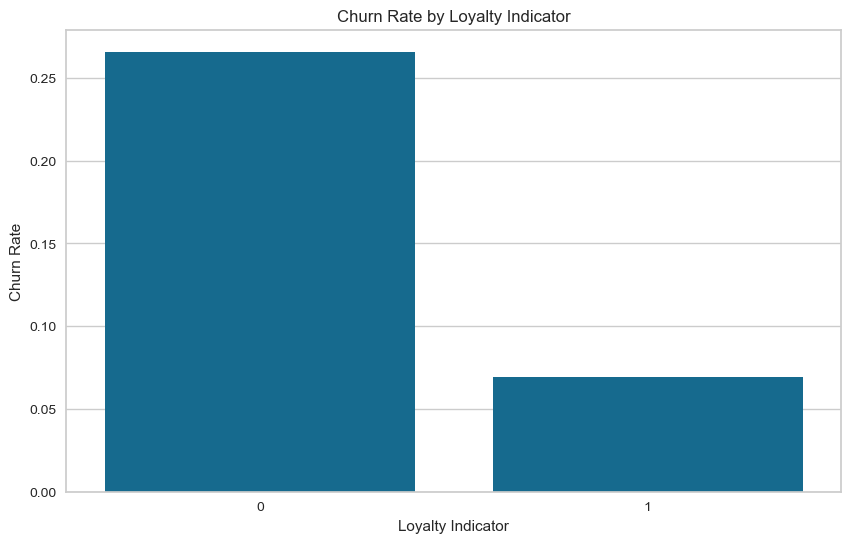

In [42]:
# Creating a bar plot to visualize the customer churn (dependent on Attrition_Flag column) for each value of Loyalty_Indicator

plt.figure(figsize = (10, 6))
sns.barplot(loyalty_summary, x = 'Loyalty_Indicator', y = 'Churn_Rate')
plt.title('Churn Rate by Loyalty Indicator')
plt.xlabel('Loyalty Indicator')
plt.ylabel('Churn Rate')
plt.show()

>From above we see that:
> * The churn rate for loyal customers is 6.4% whereas for not so loyal customers is 24.8%
> * Loyal customers have a significantly lower churn rate compared to not loyal customers
> * This indicates that our 'Loyalty_Indicator' column is effectively identifying customers who are less likely to churn
> * The bank should develop personalized offers, rewards, or benefits such as discounts, exclusive services, or loyalty programs to increase engagement and loyalty among customers classified as "Not Loyal" 

***
### Performing Train-Test Split

In [43]:
# Splitting data into X and Y

X = churners.drop('Attrition_Flag',axis = 1)  # All independent variables (i.e., excluding 'Attrition_Flag' as that is target variable)
y = churners['Attrition_Flag'] # Target variable

In [44]:
print("Shape of X -->", X.shape)
X.head()

Shape of X --> (10127, 21)


Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
0            45       0                3                2               2   
1            49       1                5                4               1   
2            51       0                3                4               2   
3            40       1                4                2               0   
4            40       0                3                1               2   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count  \
0                3            0.0        3.688879                         5   
1                1            0.0        3.806662                         6   
2                4            0.0        3.610918                         4   
3                1            0.0        3.555348                         3   
4                3            0.0        3.091042                         5   

   Months_Inactive_12_mon  ...  Credit_Limit  Total_Revolving_Bal  \
0                0.693147  ...      9.448727                  777   
1                0.693147  ...      9.018817                  864   
2                0.693147  ...      8.137103                    0   
3                1.609438  ...      8.105911                 2517   
4                0.693147  ...      8.458928                    0   

   Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0         9.385553              0.848012         7.043160              42   
1         8.908289              0.932558         7.163947              33   
2         8.137103              1.279266         7.543273              20   
3         6.680855              0.877550         7.066467              20   
4         8.458928              1.155308         6.705639              28   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Loyalty_Score  \
0             0.965081                  0.061         -0.359   
1             1.550537                  0.105         -0.139   
2             1.203873                  0.000         -0.557   
3             1.203873                  0.760         -0.889   
4             1.252763                  0.000         -1.166   

   Loyalty_Indicator  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 21 columns]

In [45]:
print("Shape of y -->", y.shape)
y.head()

Shape of y --> (10127,)


0    0
1    0
2    0
3    0
4    0
Name: Attrition_Flag, dtype: int64

In [46]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Printing the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape[0])
print("Shape of y_test:", y_test.shape[0])

Shape of X_train: (8101, 21)
Shape of X_test: (2026, 21)
Shape of y_train: 8101
Shape of y_test: 2026


***
***
## Model Building

> Though all the parts for model building are separate, we'll prefer to carry forward with all cases under this one with relative divisions to ensure differenciation

> To start with model building on original data, oversampled data and undersampled data, **we'll create few functions to optimize the process**. This will ensure we do not use the same code logic multiple times when building the models and checking on their performance metrics.
> 
> Also, to **ensure no data leakage**, we'll be prefering to use the **pipeline method** to encapsulate model fitting and it's preprocessing

> Starting off, we'll first create a function which builds and evaluates multiple models and then return the results consisting of performance metrics of different evaluated models

In [47]:
def plot_visual_metrics(model, model_name, X, y, roc_ax, conf_ax, set_type, is_roc = False, is_cm = False):
    """
    Plot ROC AUC curve and confusion matrix for a given dataset (training or test).

    Parameters:
    - model: Trained model
    - model_name: Name of the model
    - X, y: Dataset (features and labels)
    - roc_ax: Axis for plotting ROC AUC curve
    - conf_ax: Axis for plotting confusion matrix
    - set_type: Type of dataset ('Training' or 'Test')
    - is_roc: Boolean flag to check if ROC AUC curve is required
    - is_cm: Boolean flag to check if plotting a confusion matrix is required
    """
    
    # ROC AUC
    if is_roc and roc_ax:
        # Predicting the probabilities
        y_pred_proba = model.predict_proba(X)[:, 1]

        # Calculating the ROC curve
        fpr, tpr, _ = roc_curve(y, y_pred_proba)

        roc_auc = roc_auc_score(y, y_pred_proba)

        roc_ax.plot(fpr, tpr, lw = 2, label = f'ROC AUC = {roc_auc:.2f}')
        roc_ax.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
        roc_ax.set_xlim([0.0, 1.0])
        roc_ax.set_ylim([0.0, 1.05])
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.set_title(f'{model_name} - ROC AUC - {set_type} Set')
        roc_ax.legend(loc = 'lower right')

    # Confusion Matrix
    if is_cm and conf_ax:
        # Predicting the set
        y_pred = model.predict(X)

        conf_matrix = confusion_matrix(y, y_pred)

        sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', ax = conf_ax)
        conf_ax.set_title(f'{model_name} - Confusion Matrix - {set_type} Set')
        conf_ax.set_xlabel('Predicted Labels')
        conf_ax.set_ylabel('Actual Labels')
        conf_ax.set_xticks([0.5, 1.5], labels = ['Attrited Customer', 'Existing Customer'])
        conf_ax.set_yticks([0.5, 1.5], labels = ['Attrited Customer', 'Existing Customer'])

In [48]:
def plot_roc_auc_and_confusion_matrix(model, model_name, X_train, y_train, X_test, y_test):
    """
    Plot ROC AUC curve and confusion matrix for a given model.

    Parameters:
    - model: Trained model
    - model_name: Name of the model
    - X_train, y_train: Training datasets
    - X_test, y_test: Test datasets
    """
    
    if X_test is None or y_test is None:
        fig, axes = plt.subplots(1, 2, figsize = (10, 4))
        # Plot for training set
        plot_visual_metrics(model, model_name, X_train, y_train, axes[0], axes[1], 
                            set_type = 'Training', is_roc = True, is_cm = True)
    
    else:
        fig, axes = plt.subplots(2, 2, figsize = (10, 8))
        # Plot for training set
        plot_visual_metrics(model, model_name, X_train, y_train, axes[0, 0], axes[1, 0],
                            set_type = 'Training', is_roc = True, is_cm = True)
        # Plot for test set
        plot_visual_metrics(model, model_name, X_test, y_test, axes[0, 1], axes[1, 1], 
                            set_type = 'Test', is_roc = True, is_cm = True)
    
    plt.tight_layout()
    plt.show()

In [49]:
def evaluation_metrics(X_set, y_set, pipeline):
    
    """
    Evaluates the performance metrics for a given set (training or testing)
    
    Parameters:
    - X_set, y_set: The dataset to evaluate
    - pipeline: The trained pipeline model
    
    Returns:
    - The Updated results list with the metrics for the given set
    """
    
    # Making predictions on the dataset
    y_pred = pipeline.predict(X_set)
    y_pred_proba = pipeline.predict_proba(X_set)[:, 1]
    
    # Calculating the performance metrics
    metrics = {
        'Accuracy': accuracy_score(y_set, y_pred),
        'Precision': precision_score(y_set, y_pred),
        'Recall': recall_score(y_set, y_pred),
        'F1 Score': f1_score(y_set, y_pred)
    }
    
    # Adding ROC AUC only if applicable
    if hasattr(pipeline, "predict_proba"):  # to check if model supports predict_proba
        y_pred_proba = pipeline.predict_proba(X_set)[:, 1]
        metrics['ROC AUC'] = roc_auc_score(y_set, y_pred_proba)
    else:
        metrics['ROC AUC'] = None
        
    return metrics

In [50]:
def build_and_evaluate_models(X_train, y_train, X_test, y_test, sampling_method = None, scale_data = False):
    
    """
    Build and evaluate multiple models using a pipeline approach.

    Parameters:
    - X_train, y_train: Training datasets
    - X_test, y_test: Test datasets
    - sampling_method: Optional parameter for fetching the original or oversampled/undersampled data
    - scale_data: Boolean parameter to indicate if scaling is needed for our dataset

    Returns:
    - A DataFrame with model performance metrics
    """
    
    # Defining the models to evaluate
    models = {
        # Decision Tree Models
        'Decision Tree': DecisionTreeClassifier(criterion = 'gini', random_state = 42),
        'Random Forest': RandomForestClassifier(n_estimators = 10, random_state = 42),
        # Boosting Models
        'Gradient Boosting': GradientBoostingClassifier(n_estimators = 200, random_state = 42),
        'AdaBoost': AdaBoostClassifier(n_estimators = 100, random_state = 42),
        # Bagging Method
        'Bagging': BaggingClassifier(random_state = 42)
    }
    
    # Creating a DataFrame to store the performance metrics results for different models
    results = []
    
    # Iterating over each model
    for name, model in models.items():
        
        pipeline_steps = [] # to append each action as required
        
        # Create a pipeline to ensure no data leakage
        if sampling_method:
            pipeline_steps.append(('sampling', sampling_method))
        if scale_data:
            pipeline_steps.append(('scaling', RobustScaler()))
        
        pipeline_steps.append(('classifier', model))
        
        # Using ImbalancedPipeline if we are using sampling in our dataset
        if sampling_method:
            pipeline = ImbalancedPipeline(pipeline_steps)
        # else using Pipeline with original data with no sampling to keep the processing and modeling simple
        else:
            pipeline = Pipeline(pipeline_steps)
        
        # Fit the training set model
        pipeline.fit(X_train, y_train)
        
        # Evaluating on the training set
        train_metrics = evaluation_metrics(X_train, y_train, pipeline)
        
        # Evaluating on the testing set
        if X_test is not None or y_test is not None:
            test_metrics = evaluation_metrics(X_test, y_test, pipeline)
            # Combine metrics into a single dictionary for the model
            combined_metrics = {
                'Model': name,
                'Train_Set Accuracy': train_metrics['Accuracy'],
                'Test_Set Accuracy': test_metrics['Accuracy'],
                'Train_Set Precision': train_metrics['Precision'],
                'Test_Set Precision': test_metrics['Precision'],
                'Train_Set Recall': train_metrics['Recall'],
                'Test_Set Recall': test_metrics['Recall'],
                'Train_Set F1 Score': train_metrics['F1 Score'],
                'Test_Set F1 Score': test_metrics['F1 Score'],
                'Train_Set ROC AUC': train_metrics['ROC AUC'],
                'Test_Set ROC AUC': test_metrics['ROC AUC']
            }
        else:
            combined_metrics = {
                'Model': name,
                'Train_Set Accuracy': train_metrics['Accuracy'],
                'Train_Set Precision': train_metrics['Precision'],
                'Train_Set Recall': train_metrics['Recall'],
                'Train_Set F1 Score': train_metrics['F1 Score'],
                'Train_Set ROC AUC': train_metrics['ROC AUC']
            }
        
        results.append(combined_metrics)
        
        # Plotting ROC AUC and confusion matrix for each model
        plot_roc_auc_and_confusion_matrix(pipeline, name,  X_train, y_train, X_test, y_test)
        
    # Converting the list of results into a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df.round(4)

> Moving forward to create a function that takes the performance parameters from above method and then plots the ROC AUC curves for each of the model. It will also create a confusion matrix for each model for a visual representation of the results

***
### Performance Metrics for Original Data 

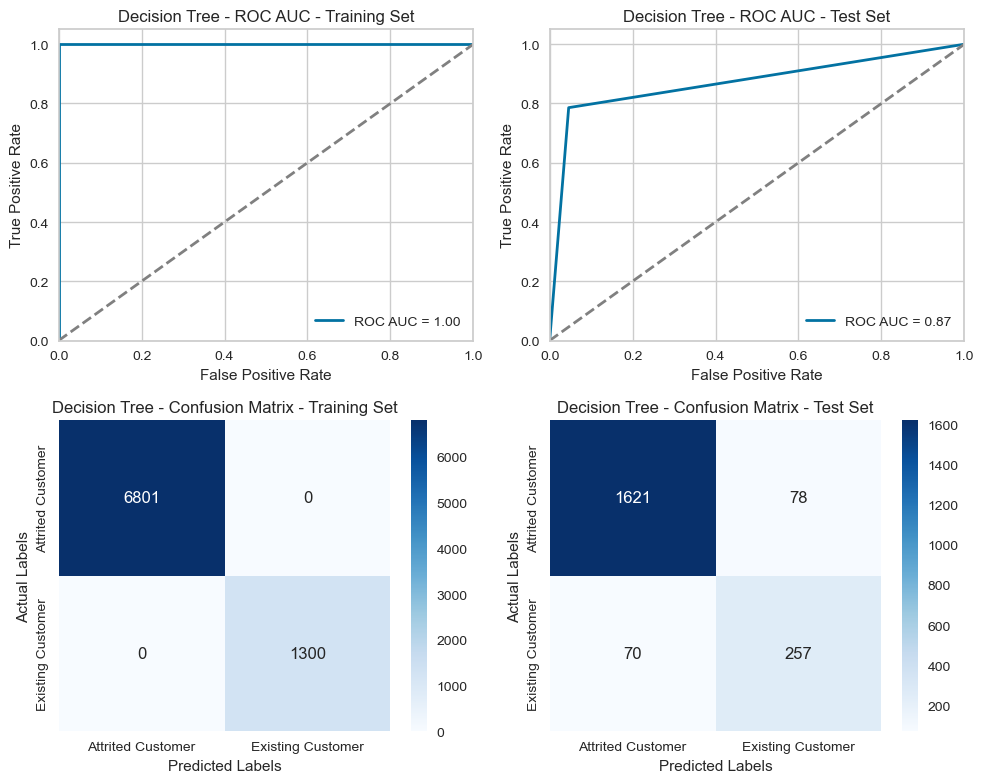

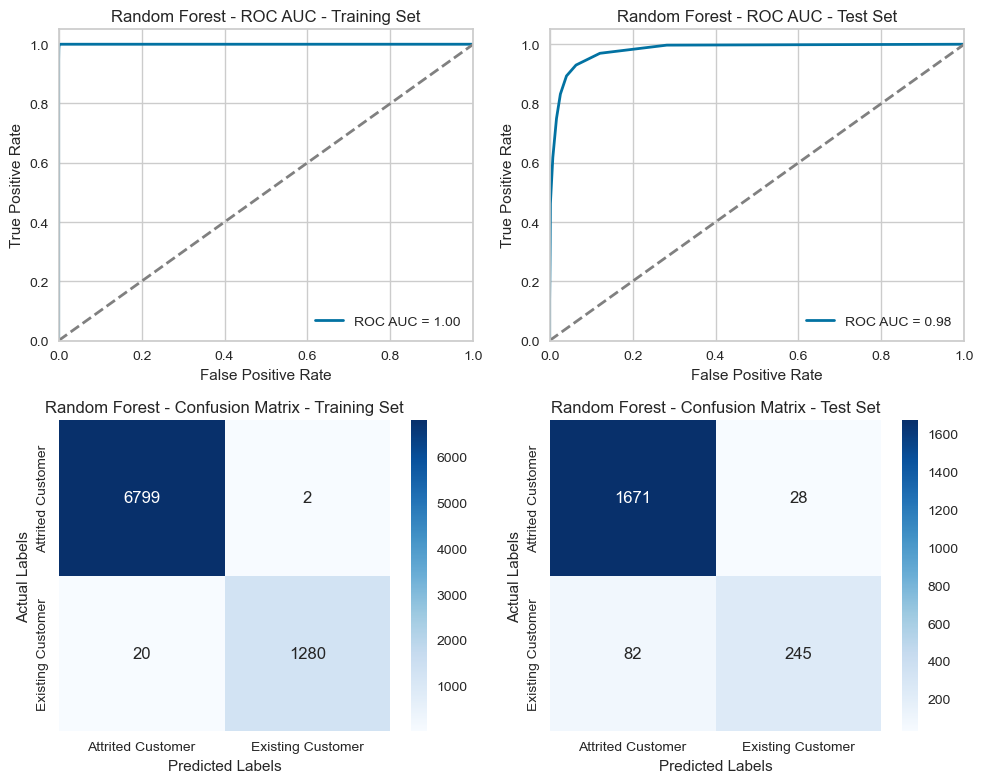

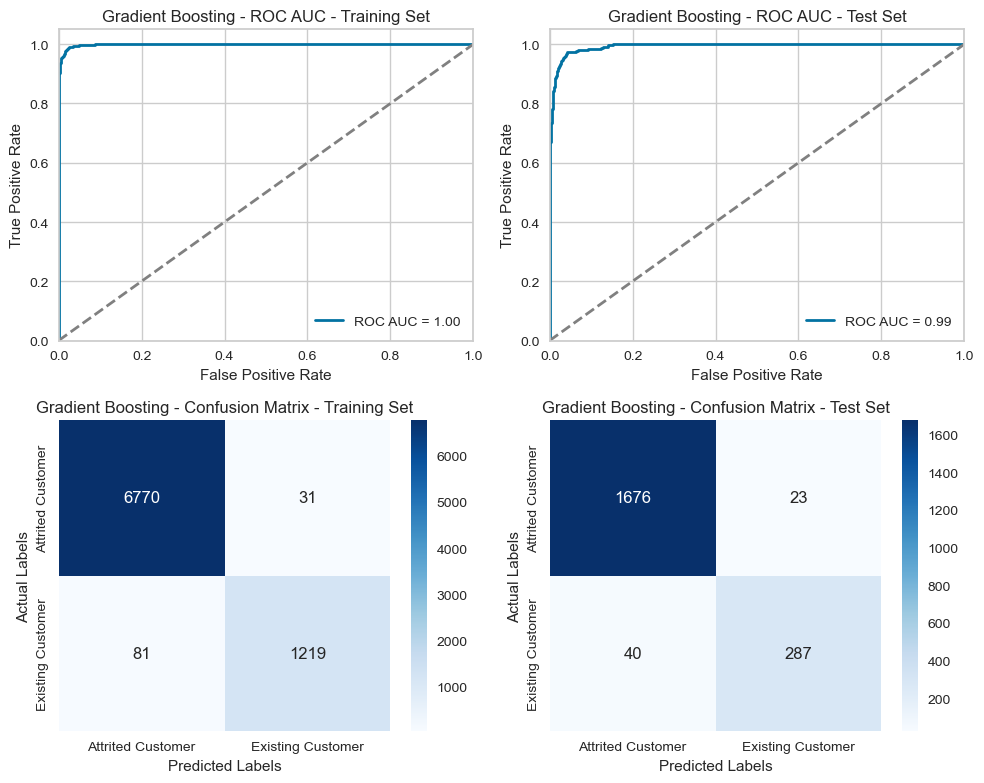

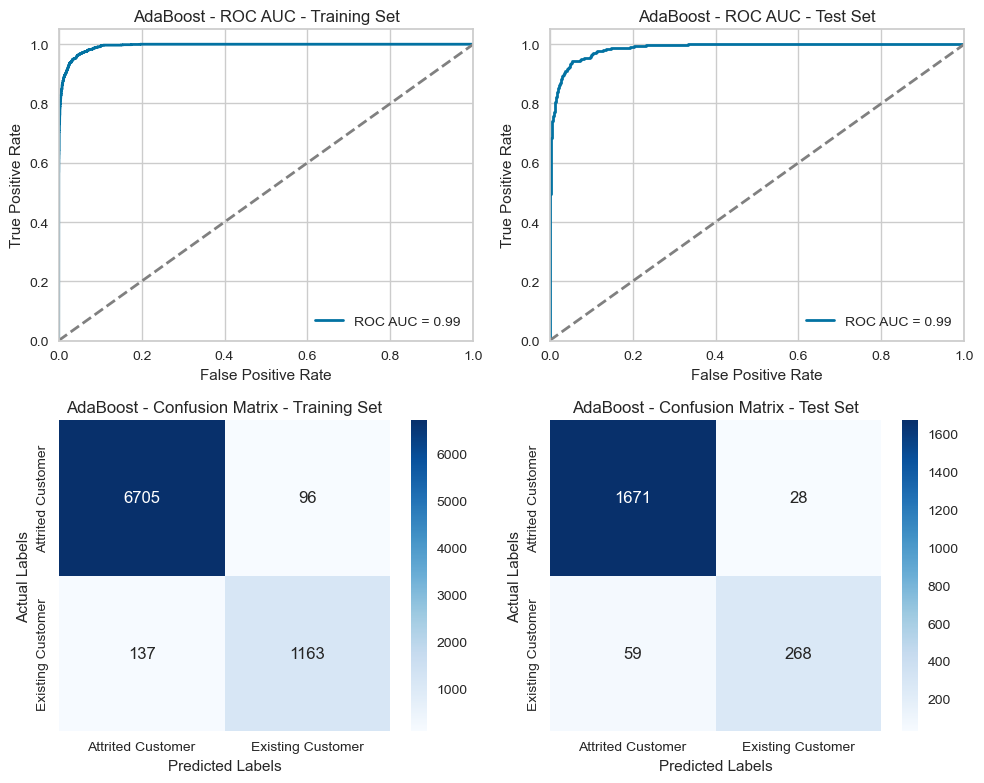

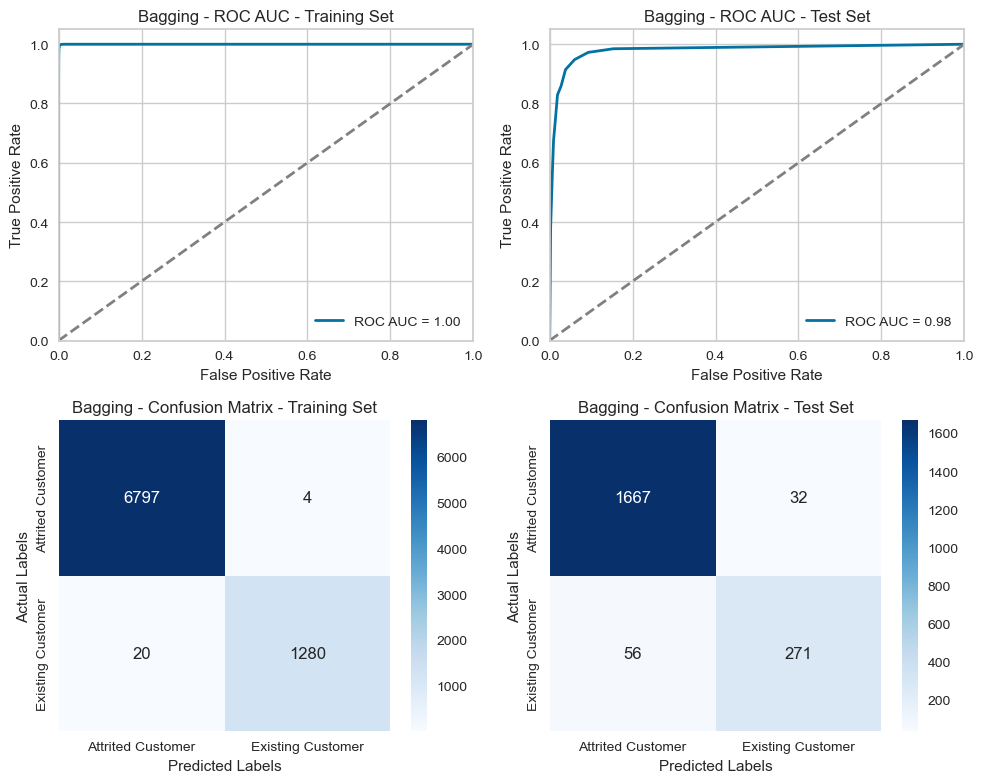


Original Data (Unscaled) Performance Metrics:


Model  Train_Set Accuracy  Test_Set Accuracy  \
0      Decision Tree              1.0000             0.9269   
1      Random Forest              0.9973             0.9457   
2  Gradient Boosting              0.9862             0.9689   
3           AdaBoost              0.9712             0.9571   
4            Bagging              0.9970             0.9566   

   Train_Set Precision  Test_Set Precision  Train_Set Recall  Test_Set Recall  \
0               1.0000              0.7672            1.0000           0.7859   
1               0.9984              0.8974            0.9846           0.7492   
2               0.9752              0.9258            0.9377           0.8777   
3               0.9237              0.9054            0.8946           0.8196   
4               0.9969              0.8944            0.9846           0.8287   

   Train_Set F1 Score  Test_Set F1 Score  Train_Set ROC AUC  Test_Set ROC AUC  
0              1.0000             0.7764             1.0000            0.8700  
1              0.9915             0.8167             1.0000            0.9805  
2              0.9561             0.9011             0.9984            0.9930  
3              0.9089             0.8604             0.9940            0.9864  
4              0.9907             0.8603             0.9999            0.9793

In [51]:
# Evaluate models on original data without scaling
original_data_results_without_scaling = build_and_evaluate_models(X_train, y_train, X_test, y_test, None, False)
print("\nOriginal Data (Unscaled) Performance Metrics:")
original_data_results_without_scaling

Based on the above visual plots and the performance metrics of the original data without scaling, let's evaluate each of our 5 mdoels in detail:

 1. Since we know that our dataset is highly imbalanced on its target variable with 83.1% of 'Existing Customers' and only 16.9% of 'Attrited Customers', we would park Accuracy as the key performance para,eter as it can be misleading for imbalanced datasets. We would focus more on other parameters, precision, recall, F1 Score, ROC AUC
 <br><br>
 2. **Decision Tree:** 
     * While the decision tree is good at an accuracy on the testing set, the perfect scores across all metrics on the training set indicate it to be a highly overfitted model
     * As we see on the confusion matrix, though we have a good training set predictions with 0 errors and all samples correctly classified, the values significantly drop on the testing set, with a noticeable number of false positives (69) and false negatives (71). This again indicates overfitting
     * The ROC AUC is a perfect 1 on the training set whereas it drops significantly for testing/unseen data. This indicates that the decision Tree model struggles to generalize
     <br><br>
 3. **Random Forest:** 
     * Similar to Decision Tree, Random Forest model also shows a near perfect performance on all the evaluation parameters on training data and fails to show the same on testing set which again idicates overfitting
     * Though it is slightly overfitted, it shows a better generalization than Decision Tree with high Precision, Recall, and ROC AUC, indicating a robust model that is capable of handling complex relationships in the data without significant overfitting
     * The confusion matrix also shows minimal misclassification with lesser false positives (19) and false negatives (69) compared to Decision Tree making it a better model in generalizing well on the dataset
     <br><br>
 4. **Gradient Boosting:**
     * This model shows a higher performance on training as well as on the testing set however, it is slightly lower than that of Random Forest model
     * It also shows an excellent generalization with strong metrics across the board, including a very high ROC AUC on testing set. This indicates that Gradient Boosting is effectively balancing training and testing performance
     * This model is also less overfitted compared to above two with a few minor errors in the confusion matrix for both training set (192 FN and FP in total) and testing sets (69 FN and FP in total), and specially on testing set which makes it the most effective model than above two
     <br><br>
 5. **AdaBoost:**
     * Adaboost also shows a good performance overall with slightly lower metrics compared to Gradient Boosting for both the type of sets. It is also more sensitive to incorrect classifications, as we see in the confusion matrices
     * The ROC AUC is high for both training set and testing set with very few misclassifications on the false positives and false negatives however, it maintains a good performance on the unseen data
     * It is also less overfitted as we see on comparison of training set with the testing one
     <br><br>
 6. **Bagging:**
     * Bagging has a near perfect metrics on training set indicating its strong fit on the set. It also shows high performance on the testing set however, misses on the Recall as compared to other models
     * There are a few misclassifications on the confusion matrix with more on the testing set compared to the training one however they are relatively low and show a strong generalization capability
     
Overall, **Gradient Boosting** and **Random Forest** models performed quite well on both the sets with **Gradient Boosting** model outperforming the Random Forest one, however, both models emerge as top performers in terms of both training and testing set accuracy

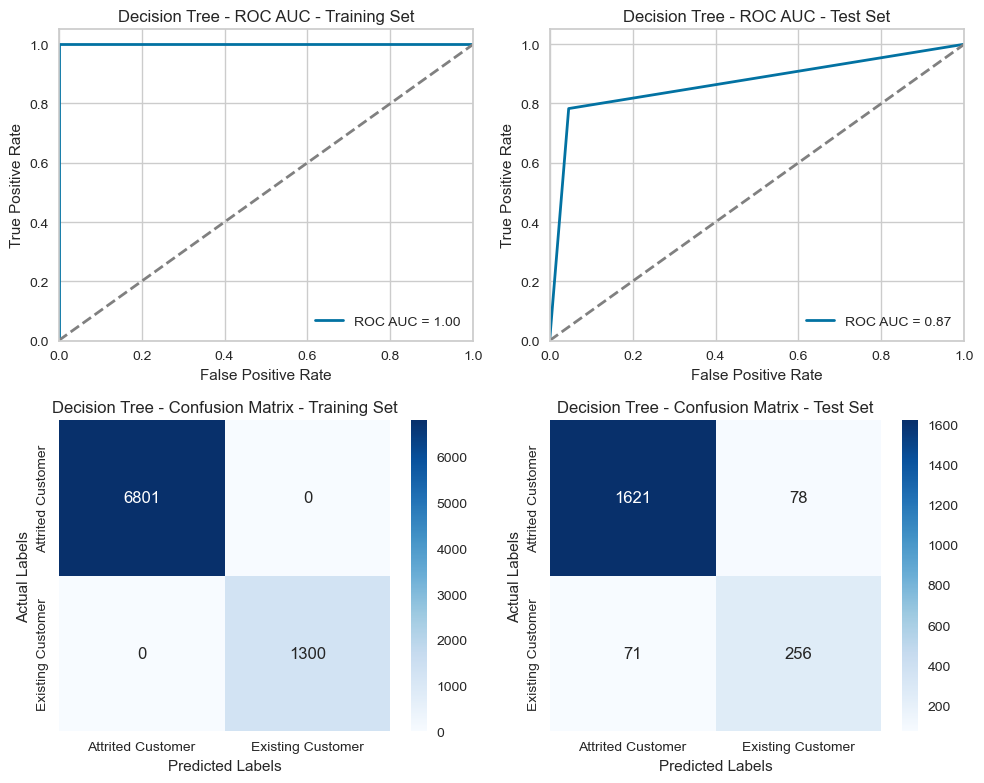

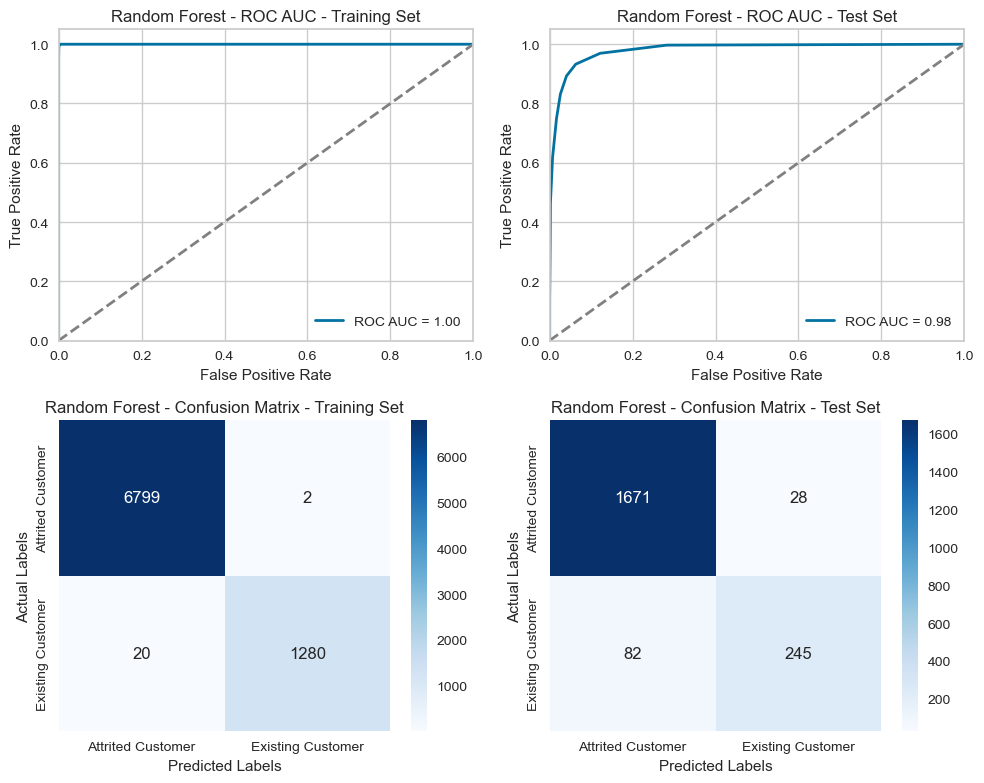

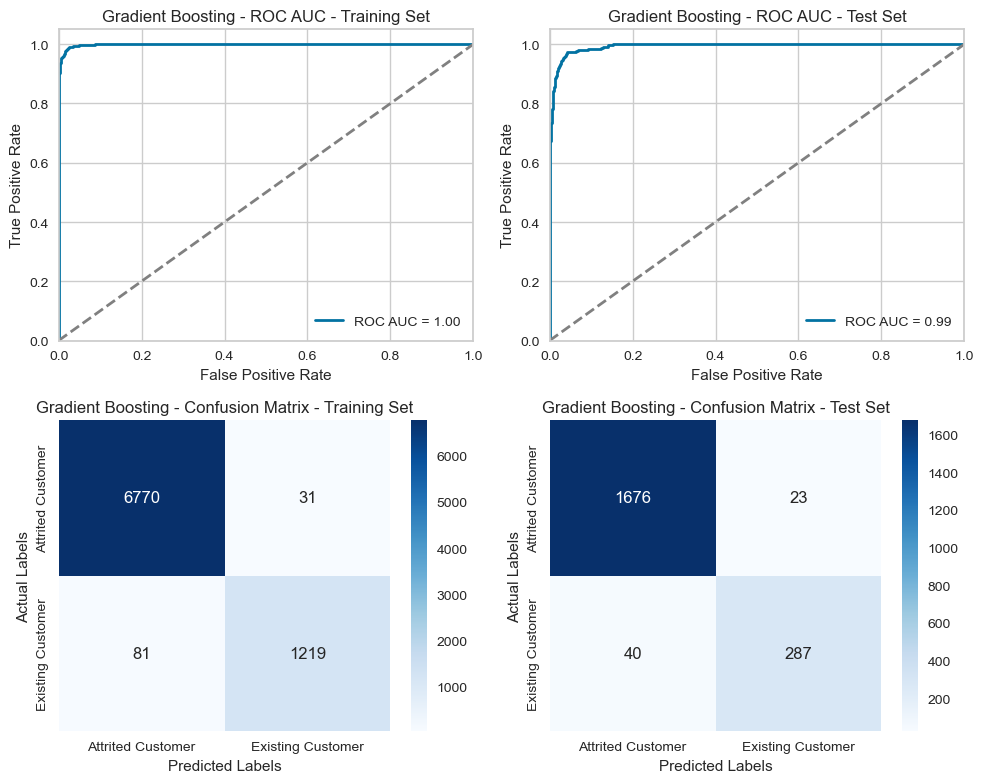

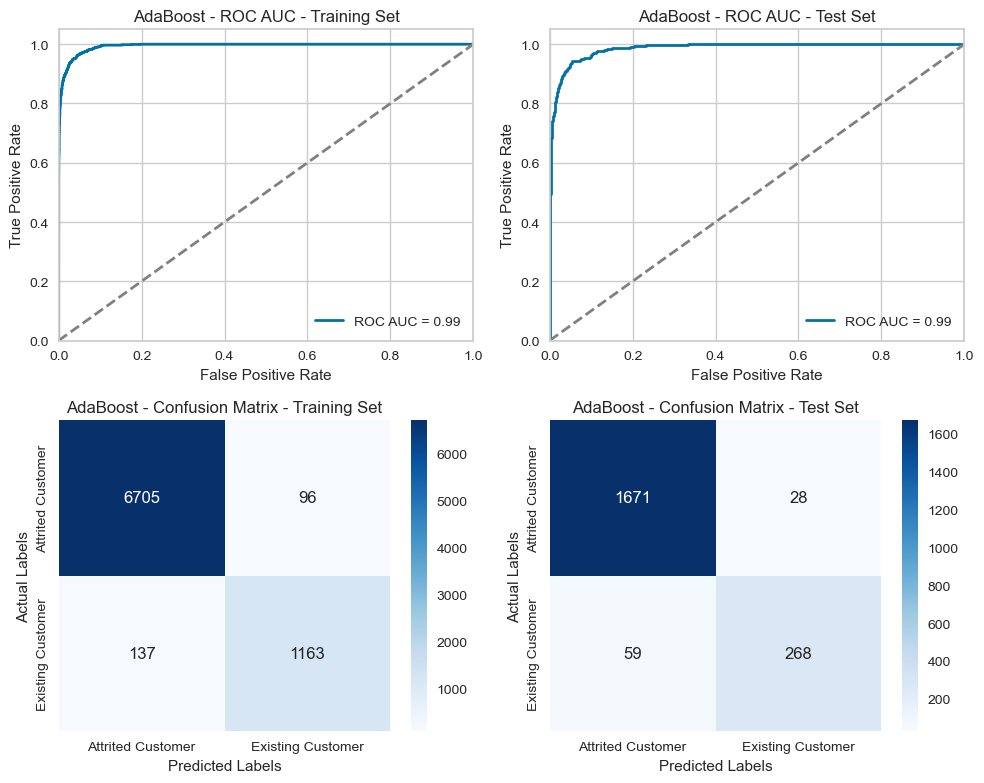

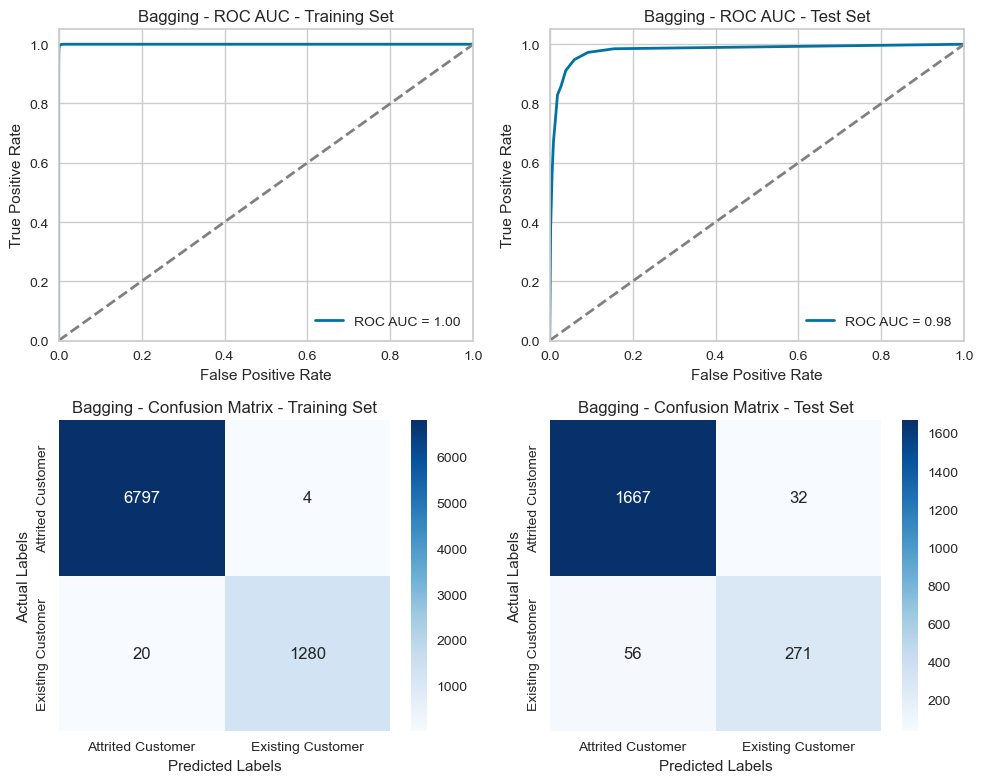


Original Data (Scaled) Performance Metrics:


Model  Train_Set Accuracy  Test_Set Accuracy  \
0      Decision Tree              1.0000             0.9265   
1      Random Forest              0.9973             0.9457   
2  Gradient Boosting              0.9862             0.9689   
3           AdaBoost              0.9712             0.9571   
4            Bagging              0.9970             0.9566   

   Train_Set Precision  Test_Set Precision  Train_Set Recall  Test_Set Recall  \
0               1.0000              0.7665            1.0000           0.7829   
1               0.9984              0.8974            0.9846           0.7492   
2               0.9752              0.9258            0.9377           0.8777   
3               0.9237              0.9054            0.8946           0.8196   
4               0.9969              0.8944            0.9846           0.8287   

   Train_Set F1 Score  Test_Set F1 Score  Train_Set ROC AUC  Test_Set ROC AUC  
0              1.0000             0.7746             1.0000            0.8685  
1              0.9915             0.8167             1.0000            0.9807  
2              0.9561             0.9011             0.9984            0.9930  
3              0.9089             0.8604             0.9940            0.9864  
4              0.9907             0.8603             0.9999            0.9793

In [52]:
# Evaluate models on original data with Robust Scaling
original_data_results_with_scaling = build_and_evaluate_models(X_train, y_train, X_test, y_test, None, True)
print("\nOriginal Data (Scaled) Performance Metrics:")
original_data_results_with_scaling

> After seeing the performance metrics for original data after scaling, we can see that the results are almost similar. This might be because the models we are using are robust to cslaing techniques. However, we'll try to perform sampling once on oversampled data to conclude on our results

***
### Performance Metrics for Over-Sampled Data 

> In order to oversample the train data, we'll be using **SMOTE(Synthetic Minority Oversampling Technique)**.
We'll be utilizing the same set of functions created before to under Model building to check the model performance

>To start with, let's resample the training data

In [53]:
oversample = SMOTE(random_state = 42)
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)

In [54]:
# Printing the shapes of the oversampled train set
print("Shape of X_train_oversampled:", X_train_oversampled.shape)
print("Shape of y_train_oversampled:", y_train_oversampled.shape[0])

Shape of X_train_oversampled: (13602, 21)
Shape of y_train_oversampled: 13602


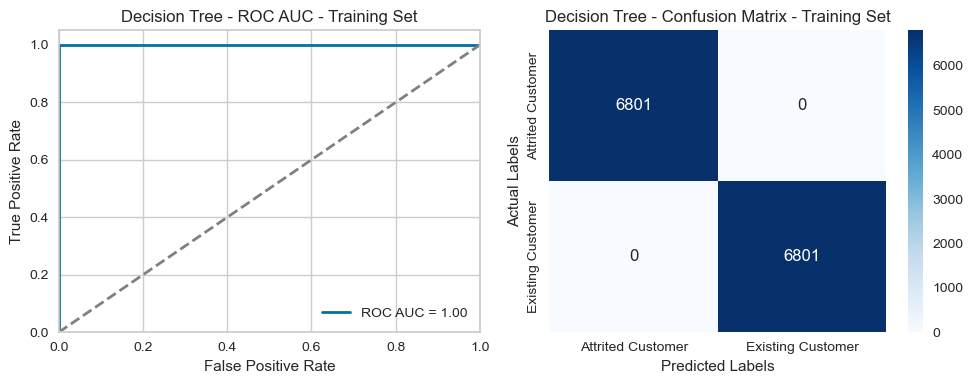

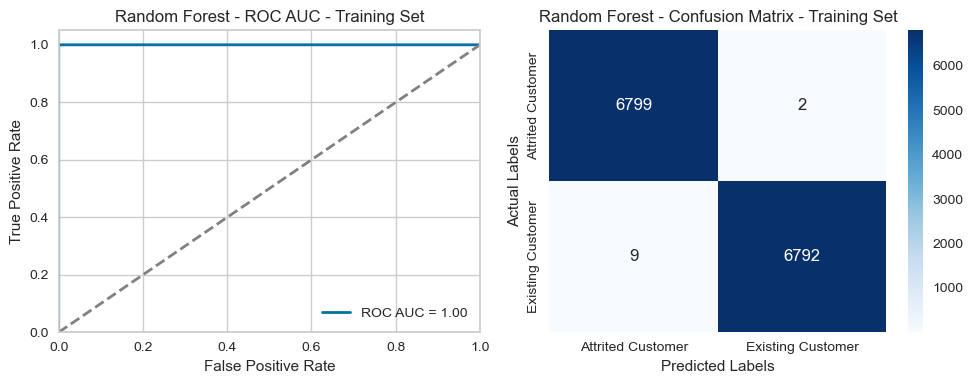

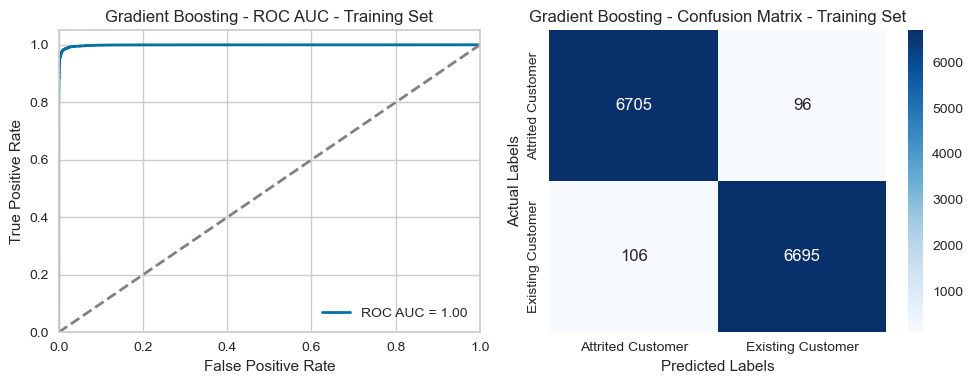

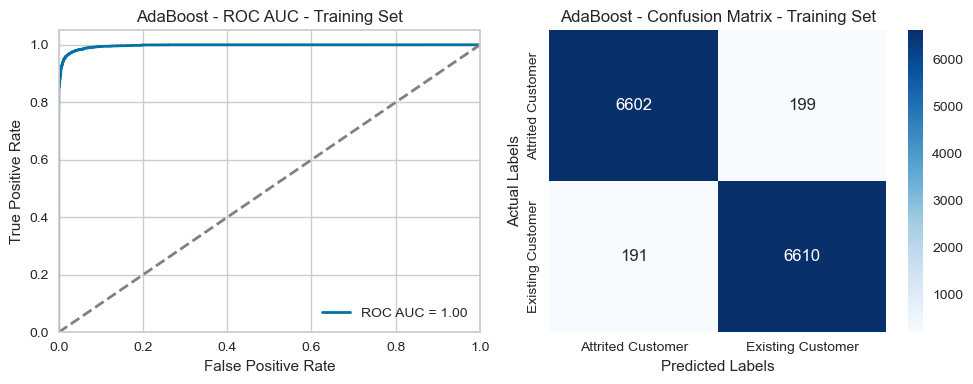

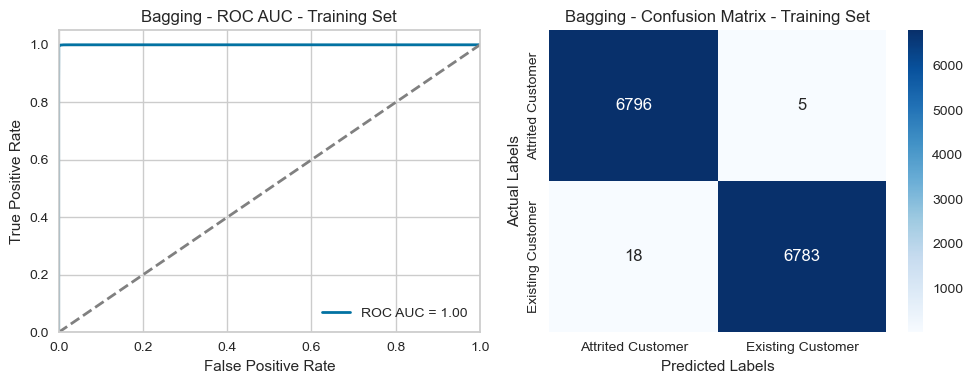


Oversampled Data (Unscaled) Performance Metrics:


Model  Train_Set Accuracy  Train_Set Precision  \
0      Decision Tree              1.0000               1.0000   
1      Random Forest              0.9992               0.9997   
2  Gradient Boosting              0.9851               0.9859   
3           AdaBoost              0.9713               0.9708   
4            Bagging              0.9983               0.9993   

   Train_Set Recall  Train_Set F1 Score  Train_Set ROC AUC  
0            1.0000              1.0000             1.0000  
1            0.9987              0.9992             1.0000  
2            0.9844              0.9851             0.9989  
3            0.9719              0.9713             0.9969  
4            0.9974              0.9983             1.0000

In [55]:
# Evaluating models on oversampled data without scaling
oversampled_data_results_without_scaling = build_and_evaluate_models(X_train_oversampled, y_train_oversampled, None, None, 
                                                                     sampling_method = oversample, scale_data = False)
print("\nOversampled Data (Unscaled) Performance Metrics:")
oversampled_data_results_without_scaling

 1. For **Decision Tree**, all the performance parameters are with a perfect score of 1.00 on the train set:
     * This indicates that the model is performing extremely well on the train set. However, However, this might indicate overfitting especially since it perfectly predicts all training samples
     * The Confusion Matrix as well shows no misclassifications, which while perfect, is highly indicative of overfitting to the training data
     <br><br>
 2. **Random Forest** has all parameters performing very well:
     * With an Accuracy of 0.9993 and Precision, Recall & F1 Score ranging from 0.9987 - 0.9997, ROC AUC value is a perfect 1, indicating a minimal risk of overfitting and high effectiveness as we have seen with any other Random Forest model
     * There are very minimal misclassifications on the confusion matrix as well
     <br><br>
 3. **Gradient Boosting** has a good balance in prediction of both positive and negative classes:
     * Though 227 existing customers are incorrectly predicted as attrited, there is a perfect score of 1.00 for ROC AUC suggesting excellent separation between the two classes
     * It also strikes a balance between accuracy and generalization
     * It offers slightly lower accuracy compared to Random Forest but is less prone to overfitting, making it a good candidate for real-world applications
     <br><br>
 4. There are slightly more misclassifications in **AdaBoost** compared to Gradient Boosting, but it still performs well overall:
     * There is a near perfect score of 0.99 for ROC AUC indicating very good class separation in this case
     * There is a high recall suggesting a good generalization compared to above tree-only models
     <br><br>
 5. There is an almost perfect score across the board for **Bagging** as well:
     * This indicates a potential overfitting however that risk is low here similar to Random Forest with high accuracy. It also shows slightly better generalization than completely perfect metrics like for Decision Tree
     * There are minimal misclassifications in the confusion matrix as well for this one
     

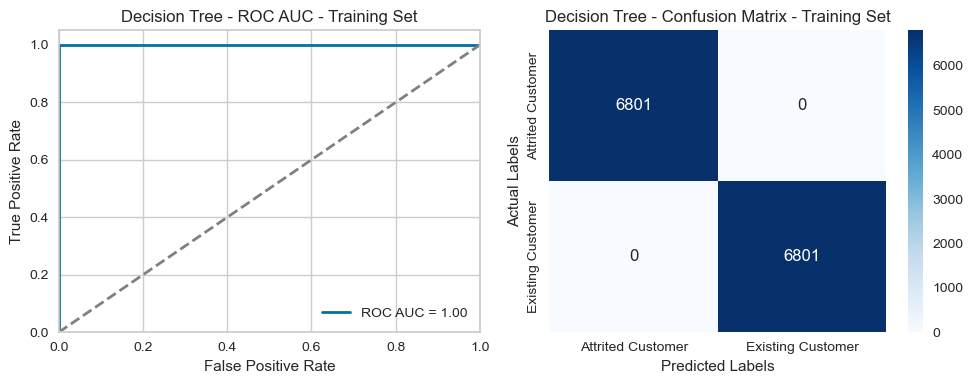

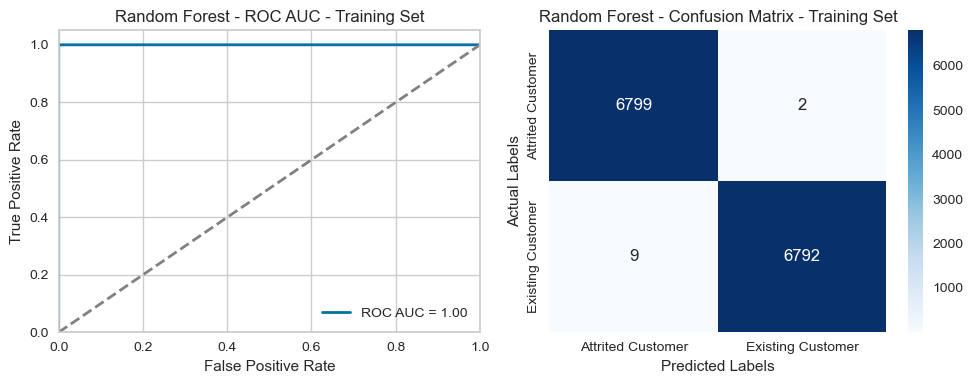

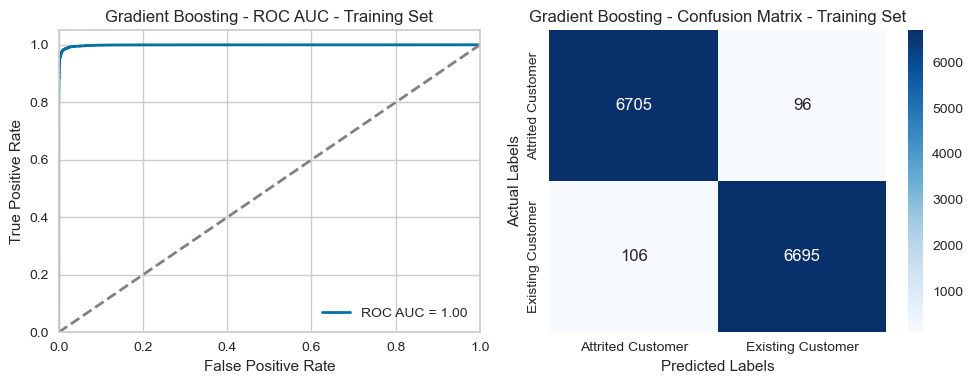

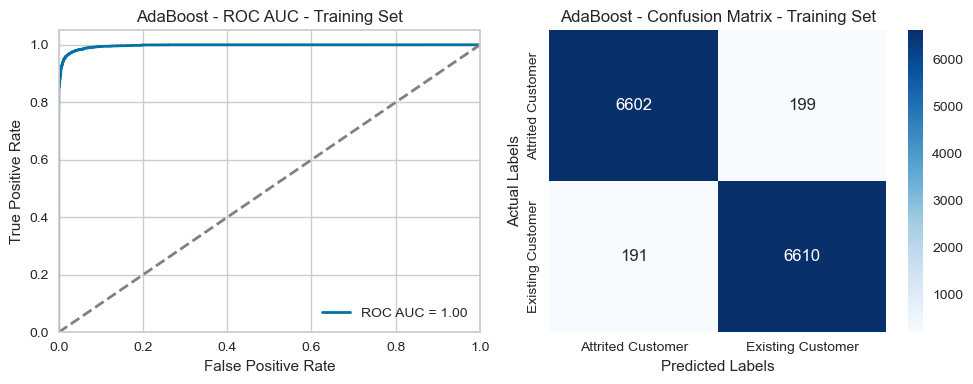

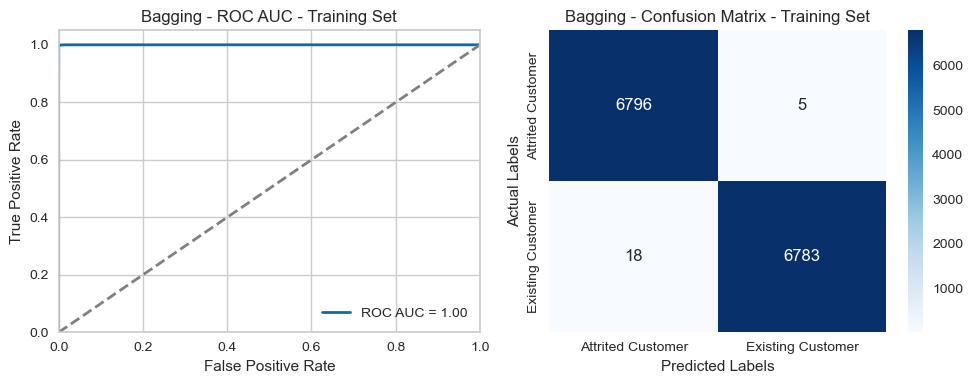


Oversampled Data (Scaled) Performance Metrics:


Model  Train_Set Accuracy  Train_Set Precision  \
0      Decision Tree              1.0000               1.0000   
1      Random Forest              0.9992               0.9997   
2  Gradient Boosting              0.9851               0.9859   
3           AdaBoost              0.9713               0.9708   
4            Bagging              0.9983               0.9993   

   Train_Set Recall  Train_Set F1 Score  Train_Set ROC AUC  
0            1.0000              1.0000             1.0000  
1            0.9987              0.9992             1.0000  
2            0.9844              0.9851             0.9989  
3            0.9719              0.9713             0.9969  
4            0.9974              0.9983             1.0000

In [56]:
# Evaluating models on oversampled data without scaling
oversampled_data_results_without_scaling = build_and_evaluate_models(X_train_oversampled, y_train_oversampled, None, None, 
                                                                     sampling_method = oversample, scale_data = True)
print("\nOversampled Data (Scaled) Performance Metrics:")
oversampled_data_results_without_scaling

>The performance metrics of Unscaled and Scaled Data for both original and oversampled sets are almost similar to identical across all models in this oversampling case as well. Let's have a deeper dive in this.

***
> The 5 models we are using for our analysis are - 
>  * Decision Tree
>  * Random Forest
>  * Gradient Boost
>  * AdaBoost
>  * Bagging
>  
> Scaling is often not required for tree-based models like above and all these models are robust to scaling techniques.
> <br>
> * **Decision Tree** and **Random Forest** models are not sensitive to the scale of the data as they make decisions based on order statistics (i.e., the ordering of values), not on their absolute values
> * **Gradient Boosting**, **AdaBoost**, and **Bagging** methods are also robust to the scale of the data, especially when the base estimators are tree-based
> * These models focus on ranks or the order of features rather than their specific values, which makes their performance invariant to the scale of the input data
> 
> Overall, the identical performance metrics indicate that scaling does not significantly impact the performance of any particular model on our dataset and due to all above reasons, we are not going forward with scaling while doing further analysis.
***

***
### Performance Metrics for Under-Sampled Data 

> For performing under-sampling, we will be moving forward with **Random Under-Sampling technique** which will remove some data from our majority class leaving us with a balanced under sampled dataset to perform analysis on.
<br> We'll be utilizing the same set of functions created before to under Model building to check the model performance

In [57]:
# Undersampling the training data
undersample = RandomUnderSampler(random_state = 42)
X_train_undersampled, y_train_undersampled = undersample.fit_resample(X_train, y_train)
X_test_undersampled, y_test_undersampled = undersample.fit_resample(X_test, y_test)

In [58]:
# Printing the shapes of the undersampled train set
print("Shape of X_train_undersampled:", X_train_undersampled.shape)
print("Shape of y_train_undersampled:", y_train_undersampled.shape[0])
print("Shape of X_test_undersampled:", X_test_undersampled.shape)
print("Shape of y_test_undersampled:", y_test_undersampled.shape[0])

Shape of X_train_undersampled: (2600, 21)
Shape of y_train_undersampled: 2600
Shape of X_test_undersampled: (654, 21)
Shape of y_test_undersampled: 654


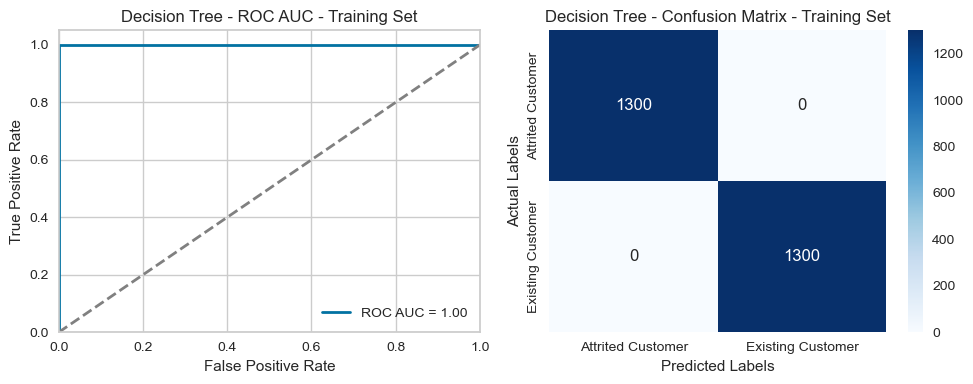

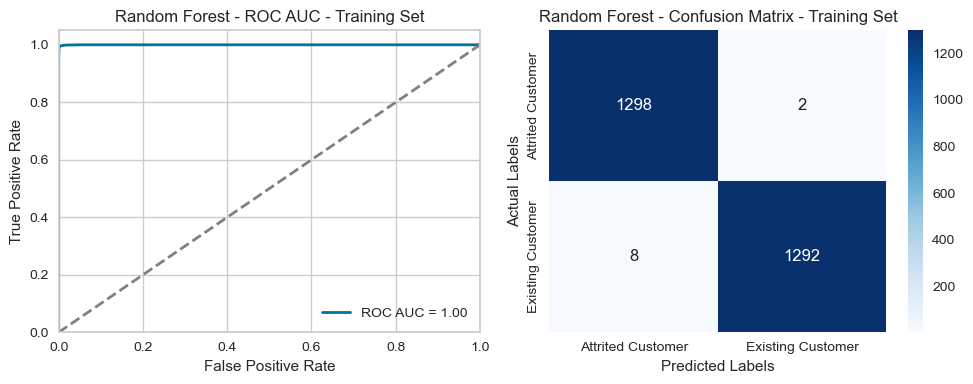

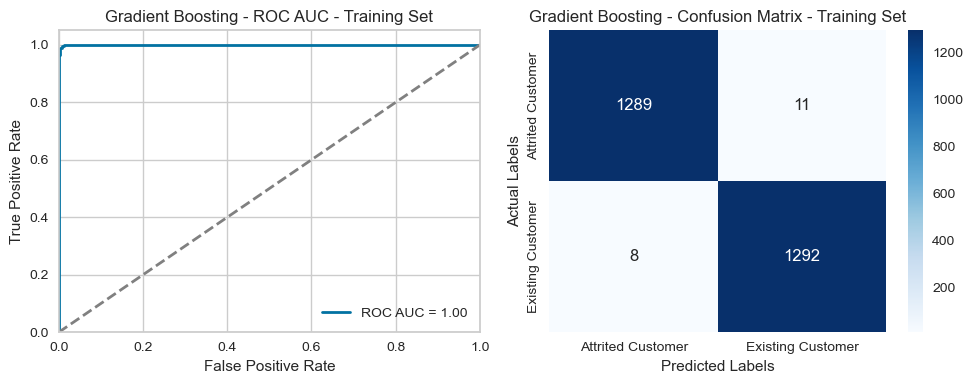

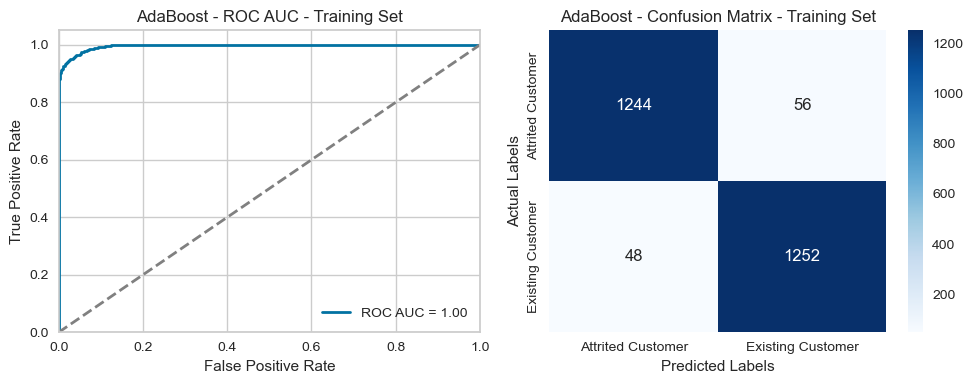

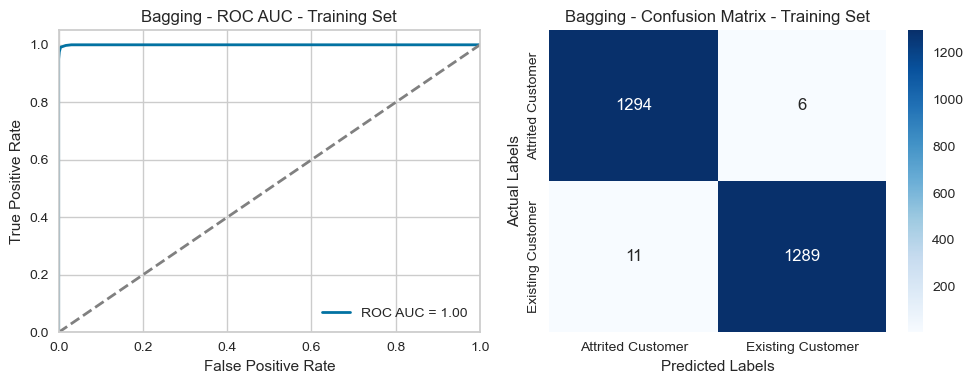


Under-sampled Data Performance Metrics:


Model  Train_Set Accuracy  Train_Set Precision  \
0      Decision Tree              1.0000               1.0000   
1      Random Forest              0.9962               0.9985   
2  Gradient Boosting              0.9927               0.9916   
3           AdaBoost              0.9600               0.9572   
4            Bagging              0.9935               0.9954   

   Train_Set Recall  Train_Set F1 Score  Train_Set ROC AUC  
0            1.0000              1.0000             1.0000  
1            0.9938              0.9961             0.9999  
2            0.9938              0.9927             0.9998  
3            0.9631              0.9601             0.9958  
4            0.9915              0.9934             0.9998

In [59]:
# Evaluating models on undersampled data without scaling
undersampled_data_results = build_and_evaluate_models(X_train_undersampled, y_train_undersampled, None, None, 
                                                                     sampling_method = undersample, scale_data = False)
print("\nUnder-sampled Data Performance Metrics:")
undersampled_data_results

The performance metrics and visualizations from the ROC curves and confusion matrices offer insights into how each model handles the undersampled data and the performance across board
 1. **Decision Tree:** 
     * It perfectly classified all instances on the training set, with no misclassifications
     * This indicates a high risk of overfitting to the under-sampled data, which is concerning as it might not generalize well to unseen data
     <br><br>
 2. **Random Forest:** 
     * The confusion matrix is showing a small number of  misclassifications as well. The slight drop from perfect scores indicates a well-balanced model that can generalize better than the Decision Tree, reducing the risk of overfitting
     * The ROC AUC is alomost touching a perfect score showing a strong balance between model complexity and performance with generalizing well
     <br><br>
 3. **Gradient Boosting:**
     * This also performs exceptionally well, slightly trailing Random Forest
     * Its performance suggests it is robust in predicting correct churn of customers
     * Similar to Random Forest, Gradient Boosting has a few misclassifications, but generally performs very well
     <br><br>
 4. **AdaBoost:**
     * Adaboost has the least performance here among all the 5 models, however it shows a strong performance overall with less chances of overfitting
     * It exhibits a higher number of misclassifications compared to the other models, particularly with false positives and false negatives suggesting that it captures the results with few incorect interpretaions when compared to other ensemble techniques
     <br><br>
 5. **Bagging:**
     * Bagging shows a very low number of misclassifications, similar to Random Forest with a good generalization
     * Its balance between precision and recall is strong which make it a good candidate for accurate predictions in this case of undersampled dataset

>Overall, when comparing performance across over-sampled, original, and under-sampled datasets:
>
> * **Oversampling** tends to inflate training performance, while **undersampling** offers a more conservative and potentially more generalizable performance metric
> * All models show either perfect or nearly perfect metrics on the training set with oversampled data, suggesting possible overfitting—particularly for Decision Trees and Random Forests, which score a perfect 1.0 across all metrics
> * On the **original data**, models like Gradient Boosting and AdaBoost demonstrate robust generalization capabilities, maintaining high test set accuracy and ROC AUC scores. This indicates that while oversampling may boost training performance, it doesn’t necessarily enhance the models' ability to generalize to new, unseen data
> * The Decision Tree and Random Forest models consistently exhibit high or perfect metrics on the training set, further pointing to potential overfitting, mostly with Decision Tree as Random Forest is less prone to overfit
> * Gradient Boosting, AdaBoost, and Bagging also perform strongly across different sampling methods, with **Gradient Boosting showing particularly impressive performance in all scenarios**
> * Undersampling slightly decreases performance metrics compared to oversampling, likely due to the reduced size of the training data

***
***
## Model Performance Improvement using Hyperparameter Tuning

> Since, for model performance improvement through hyperparameter tuning, we ought to choose at least 3 models that might perform better after tuning, we would see what all models to tune, why these are chosen and what all parameters will be used to tune the respective models. This approach ensures that the selected models are fine-tuned based on their specific characteristics and common challenges, maximizing the potential improvements in their performance

> To start with the model selection, We would be considering the models' base performance and how much they might improve with adjustments to their parameters and are moving forward with below 3 models:
> * Random Forest
> * Gradient Boost
> * AdaBoost

 1. **Random Forest:** 
     * **Why Random Forest? -** Although Random Forest performs well overall, it tends to show signs of overfitting with perfect training scores. Tuning can help in reducing overfitting and improving model generalization to new, unseen data
     * **Parameters to Tune -** 
         - _n_estimators: Number of trees in the forest_
         - _max_depth: The maximum depth of each tree. Setting this parameter can help in controlling overfitting_
         - _max_features: The number of features to consider when looking for the best split_
         - _min_samples_split: The minimum number of samples required to split an internal node. Higher values prevent overfitting_
         - _min_samples_leaf: The minimum number of samples required to be at a leaf node_
     * We will use hypertuning on Random Forest to minimize overfitting while improving recall and overall test set performance
 <br><br>
  2. **Gradient Boost:** 
     * **Why Gradient Boost? -** Though it already shows strong performance across various datasets, it has potential for even further improvement. It is also a powerful ensemble method that can benefit significantly from hyperparameter optimization, particularly in terms of the number of boosting stages and the depth of each tree
     * **Parameters to Tune -** 
         - _n_estimators: Number of boosting stages to perform. Increasing this number can lead to better performance but risk overfitting_
         - _max_depth: Controls the depth of each tree_
         - _learning_rate: Shrinks the contribution of each tree_
         - _subsample: The fraction of samples to be used for fitting the individual base learners_
     * We'll tune Gradient Boost model to improve the generalization of the model while preventing overfitting
 <br><br>
  3. **AdaBoost:** 
     * **Why AdaBoost? -** We've seen a variability in this particular model's performance and tuning might stabilize and enhance its effectiveness. By adjusting its parameters, we can potentially increase its precision and recall
     * **Parameters to Tune -** 
         - _n_estimators: Number of weak learners to train iteratively_
         - _learning_rate: Weight applied to each classifier at each boosting iteration_
         - _base_estimator: Tuning the base estimator can lead to significant improvements_
     * We will be tuning AdaBoost to balance it's precision and recall better while reducing the bias
 <br>
 
**Why not Decision Tree and Bagging?**
 * Decision Tree is more overfitted overall and does not lack it. Also, the simplicity of Decision Trees might not yield significant improvements in generalization or performance.
 * The robust nature of Bagging might not benefit more from the hyper-tuning techniques and tuning this might not increase the performance significantly as much as the boosting methods

> Now that we have our 3 models chosen to perform hyperparameter tuning, we will explore the technique we'll be using to tune the parameters.
> <br><br>Since, we have a larget dataset to work on, GridSearch might take more time for computation and might not be a good choice here. 
> <br><br>We can go with **RandomizedSearchCV (Randomized Search with Cross Validation)** as Random Search is generally faster than GridSearchCV because it does not evaluate all combinations of hyperparameters, allowing for broader exploration within a limited computational budget. Cross validation will also ensure that each hyperparameter configuration is tested for generalizability

>Let's will start with creating a function to perform the hyperparameter tuning for each model selected

In [60]:
# Perform Grid Search on model

def perform_random_search(model, parameters, X_set, y_set):
    """
    Performs a Randomized Search for specific model along with time taken to fetch the best parameters
    Input Parameters:
    model: The model on which we need to perform RandomizedSearch
    parameters: The parameters to do randomized search
    X_set: Dataset of independent variables
    y_set: Dataset of target variable
    """
    
    print(f"\n Running RandomizedSearchCV for model: {model}")
    # print(f"\n Parameters being used: {parameters}\n")
    
    # Initializing Randomized Search
    # verbose = 1 will print the log inline while performing the search
    random_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, cv = 5, 
                                       n_iter = 50, n_jobs = -1, verbose = 1)

    model_name = model.__class__.__name__.replace('Classifier', '')
    
    # Training the model
    start_time_fit = time.time();
    random_search.fit(X_set, y_set)
    end_time_fit = time.time();
    
    time_to_fit = end_time_fit - start_time_fit

    # Getting the best parameters found by Random Search
    best_parameters = random_search.best_params_
    print(f"\n Best Parameters found by Randomized Search on {model_name} Model - \n       ", best_parameters)
    
    if(time_to_fit < 60):
        print(f"\n {model_name} Randomized Search Tuning Time:", format((time_to_fit), '.2f'), "seconds") 
    else:
        print(f"\n {model_name} Randomized Search Tuning Time:", format((time_to_fit/60), '.2f'), "minutes") 
    
    return random_search

In [61]:
# Function for printing the tuned model results and show visual representation
def print_tuned_results(X_set, y_set, model, model_name, set_type, isVisual = True):
    
    """
    Prints the required visual representation of performance results
    Input Parameters:
    - model: The model on which we need to perform RandomizedSearch
    - model_name: Name of the model
    - X_set, y_set: Datasets (features and labels)
    - set_type: Type of dataset ('Training' or 'Test')
    - isVisual: Boolean flag to decide if visual representation is required
    """
    # To get the evaluation metrics results
    tuned_metrics = evaluation_metrics(X_set, y_set, model)
    
    # To store the final results
    tuned_results = [] 
    
    combined_tuned_metrics = {
        'Model': model_name,
        'Accuracy': tuned_metrics['Accuracy'],
        'Precision': tuned_metrics['Precision'],
        'Recall': tuned_metrics['Recall'],
        'F1 Score': tuned_metrics['F1 Score'],
        'ROC AUC': tuned_metrics['ROC AUC']
    }

    tuned_results.append(combined_tuned_metrics)

    # Plotting the visual metrics for our model
    if isVisual: # Only plotting if required
        fig, ax = plt.subplots(figsize = (6, 4))

        plot_visual_metrics(model, model_name, X_set, y_set, None, ax, set_type, False, True)

    # Converting the list of results into a DataFrame
    tuned_results_df = pd.DataFrame(tuned_results)

    return tuned_results_df.round(4)

In [62]:
# Craeted the function to build each selected model, tune it and print the evaluated results

def build_tuned_models_and_evaluate(X_set, y_set, models, parameters):
    """
    Build and evaluate multiple models

    Parameters:
    - X_set, y_set: Datasets
    - models: A dictionary containing the model names and the initialized model objects
    - parameters: A dictionary containing the model names and their respective parameter grids

    Returns:
    - A DataFrame with tuned models' performance metrics
    """
    
    # Creating a DataFrame to store the performance metrics results for different models
    tuned_results = []
    
    # Iterating over each model
    for model_name, model in models.items():
        print(f"\n\nTuning {model_name}...")
        
        # Performing random search with cross-validation on the model
        random_search_model = perform_random_search(model, parameters[model_name], X_set, y_set)
        
        # Getting the best estimator from random search
        best_model = random_search_model.best_estimator_
        
        # Evaluating the best model on the training set
        tuned_model_result = print_tuned_results(X_set, y_set, best_model, f"Tuned {model_name}", "Training")
        
        # Storing the tuned results
        tuned_results.append(tuned_model_result)
    
    # Combining the tuned model results into a single DataFrame
    tuned_results_df = pd.concat(tuned_results).reset_index(drop = True)
    
    return tuned_results_df

>Now that we are done with our function creation, let's define the parameters for perfroming RandomizedSearch for different selected models

In [63]:
# Defining the parameter grids for each model

param_grids = {
    # Random Forest
    'Random Forest' : {
        'n_estimators': [50, 100, 150, 200, 250, 300], # the number of trees in our forest
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20, 25, 30], # maximum depth of the random forest
        'min_samples_split': [5, 10, 20, 30], # these are the maximim number of samples required to split an internal node
        'min_samples_leaf': [2, 5, 10], # minimum number of samples required to be at the tree node
        'max_features': ['auto', 'sqrt', 'log2'] # this sets the maximum number of features to be considered for splitting
    },
    
    # Gradient Boosting
    'Gradient Boosting' : {
        'n_estimators': [50, 100, 150, 200, 250], # the number of boosting stages to be run
        'learning_rate': [0.001, 0.01, 0.05, 0.1], # this will reduce the contribution of each tree by the specified amount
        'max_depth': [2, 3, 4], # the maximum depth of individual tree
        'subsample': [0.5, 0.6, 0.7], # the fraction of samples to be used for fitting the individual base learners
        'min_samples_split': [10, 20, 30], #the minimum number of samples required to split an internal node.Helps control overfit
        'max_features': ['auto', 'sqrt', 'log2'], # the number of features to consider when looking for the best split
        'min_samples_leaf': [2, 5, 10] # the minimum number of samples required to be at a leaf node. Helps control overfitting
    },

    # AdaBoost
    'AdaBoost' : {
        'n_estimators': [50, 100, 150, 200], # number of estimators
        'learning_rate': [0.001, 0.01, 0.05, 0.1], # contribution of base estimator to the final model
        'algorithm': ['SAMME', 'SAMME.R'] # boosting algorithm to be used
    }
}

# Defining the models to evaluate and tune
models_to_tune = {
    'Random Forest': RandomForestClassifier(n_estimators = 10, random_state = 42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators = 200, random_state = 42),
    'AdaBoost': AdaBoostClassifier(n_estimators = 100, random_state = 42)
}

> We will be proceeding with performing the hyperparameter tuning on all 3 - oversampled data, undersampled data and original data, as we have a highly imbalanced data with 83.1% of 'Existing Customers' and only 16.9% of 'Attrited Customers':
> * Oversampled data might have a better generalization for this large imbalane
> * Using undersampled data might show a different perspective of all the models' perfromance
> * Original data might give insights on models' performance on the initial dataset making our analysis easier on whether sampling techniques are effective on tuned sets
>
> This way we will be able to check which model performs best on what kind of dataset


 Models to be Tuned on Oversampled Data: dict_keys(['Random Forest', 'Gradient Boosting', 'AdaBoost'])


Tuning Random Forest...

 Running RandomizedSearchCV for model: RandomForestClassifier(n_estimators=10, random_state=42)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Parameters found by Randomized Search on RandomForest Model - 
        {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini'}

 RandomForest Randomized Search Tuning Time: 1.66 minutes


Tuning Gradient Boosting...

 Running RandomizedSearchCV for model: GradientBoostingClassifier(n_estimators=200, random_state=42)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Parameters found by Randomized Search on GradientBoosting Model - 
        {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 4, 'learning_rate': 0.1}

 GradientBoostin

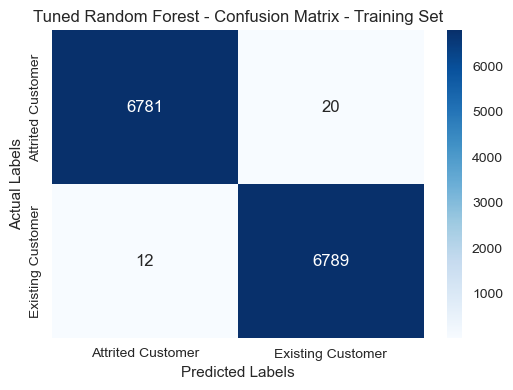

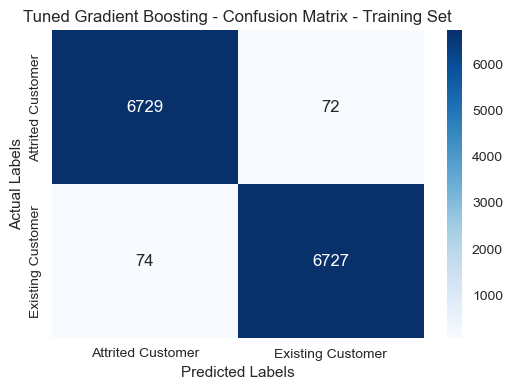

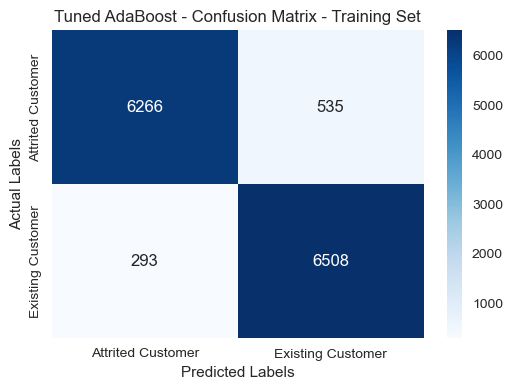

In [64]:
# Printing the final results for tuned models on oversampled data
print("\n Models to be Tuned on Oversampled Data:", models_to_tune.keys())

tuned_results_df = build_tuned_models_and_evaluate(X_train_oversampled, y_train_oversampled, models_to_tune, param_grids)

In [65]:
print("\nTuned Model Performance Metrics (On the oversampled Dataset):")
tuned_results_df


Tuned Model Performance Metrics (On the oversampled Dataset):


Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0      Tuned Random Forest    0.9976     0.9971  0.9982    0.9976   1.0000
1  Tuned Gradient Boosting    0.9893     0.9894  0.9891    0.9893   0.9995
2           Tuned AdaBoost    0.9391     0.9240  0.9569    0.9402   0.9870

<br>Here are some insights based on the above models' tuning results:
 1. **Performance:** The Random Forest model demonstrated the highest accuracy, followed closely by Gradient Boosting. AdaBoost, while lower in accuracy, still performed well, particularly in handling imbalanced data, as evidenced by its ROC AUC of 0.9859
 <br><br>
 2. **Precision and Recall:** AdaBoost showed strong precision and recall, making it a reliable model for identifying the minority class (attrited customers). However, the comparative low scores in precision suggests that it may slightly over-predict the minority class
 <br><br>
 3. **Efficiency:** AdaBoost had the shortest tuning time (43.21 seconds), indicating its computational efficiency. In contrast, Random Forest and Gradient Boosting took 1.66 minutes and 1.21 minutes, respectively, reflecting the complexity of these models. The focus area depends on need of the situation where AdaBoost can be considered when precision is not concern
 <br><br>
 4. **Parameter Optimization:** The RandomizedSearchCV process successfully optimized parameters for each model, with significant improvements in performance. For example, the Random Forest model's best parameters (e.g., n_estimators: 300, max_depth: 15) contributed to its highest accuracy and AUC scores compared to all models
 <br>
 
These insights suggest that while all models performed well, Random Forest might be the most reliable overall, with Gradient Bososting being a strong contender, especially for imbalanced data scenarios. Let's check on other types of datasets as well before concluding


 Models to be Tuned on Original Data: dict_keys(['Random Forest', 'Gradient Boosting', 'AdaBoost'])


Tuning Random Forest...

 Running RandomizedSearchCV for model: RandomForestClassifier(n_estimators=10, random_state=42)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Parameters found by Randomized Search on RandomForest Model - 
        {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}

 RandomForest Randomized Search Tuning Time: 54.21 seconds


Tuning Gradient Boosting...

 Running RandomizedSearchCV for model: GradientBoostingClassifier(n_estimators=200, random_state=42)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Parameters found by Randomized Search on GradientBoosting Model - 
        {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 4, 'learning_rate': 0.1}

 GradientBoos

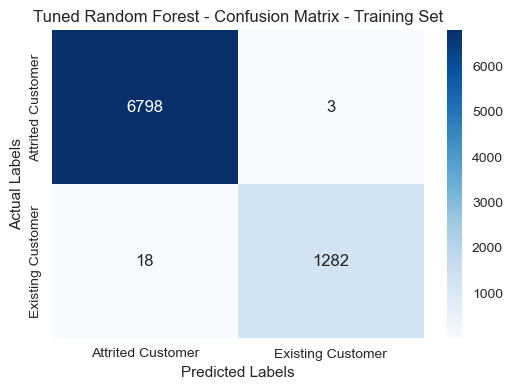

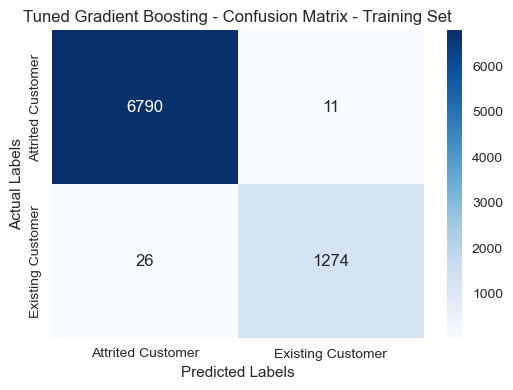

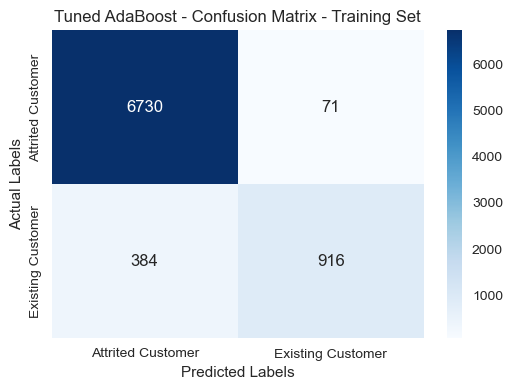

In [66]:
# Printing the final results for tuned models on original data
print("\n Models to be Tuned on Original Data:", models_to_tune.keys())

tuned_results_df = build_tuned_models_and_evaluate(X_train, y_train, models_to_tune, param_grids)

In [67]:
print("\nTuned Model Performance Metrics (On the Original Datset):")
tuned_results_df


Tuned Model Performance Metrics (On the Original Datset):


Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0      Tuned Random Forest    0.9974     0.9977  0.9862    0.9919   1.0000
1  Tuned Gradient Boosting    0.9954     0.9914  0.9800    0.9857   0.9999
2           Tuned AdaBoost    0.9438     0.9281  0.7046    0.8010   0.9829

<br>The analysis seeing the performance above can be noted down as:
1. **Performance:** The Random Forest model exhibits the best performance, with the lowest number of false positives (3) and false negatives (29). This indicates superior precision and recall, making it the most reliable model for this type of dataset
<br><br>
2. **Efficiency:** AdaBoost was the quickest to tune, taking only 24.9 seconds, followed by Gradient Boosting (29.05 seconds) and Random Forest (51.62 seconds). Despite being slower, Random Forest's additional tuning time contributed to its superior accuracy
<br><br>
3. **Balance between Precision and Recall:** Random Forest balanced precision and recall effectively, with a low false negative rate, which is crucial for detecting the minority class. Gradient Boosting as well gave a tough competetion here however, AdaBoost, despite lower tuning time, struggled to maintain this balance
<br><br>
4. **Model Choice:** Given the performance metrics and tuning times, Random Forest stands out as the best model for this however, the perfect scores also indicate some level of overfitting in this case. Gradient Boost, on the other hand, gave an overall good precision and ROC AUC scores making it a reliable choice, particularly for applications where minimizing both false positives and false negatives is critical
<br>

From above we see that though Random Forest performed quite well in all areas for this dataset, it indicated some level of overfitting. While Gradient Boost can be a good choice here, it also lacked at some places to identify the classifications with 19 false positives and 51 false negatives. Let's check on other dataset as well before making a choice


 Models to be Tuned on Undersampled Data: dict_keys(['Random Forest', 'Gradient Boosting', 'AdaBoost'])


Tuning Random Forest...

 Running RandomizedSearchCV for model: RandomForestClassifier(n_estimators=10, random_state=42)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Parameters found by Randomized Search on RandomForest Model - 
        {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}

 RandomForest Randomized Search Tuning Time: 18.40 seconds


Tuning Gradient Boosting...

 Running RandomizedSearchCV for model: GradientBoostingClassifier(n_estimators=200, random_state=42)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Parameters found by Randomized Search on GradientBoosting Model - 
        {'subsample': 0.6, 'n_estimators': 250, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.1}

 Gradient

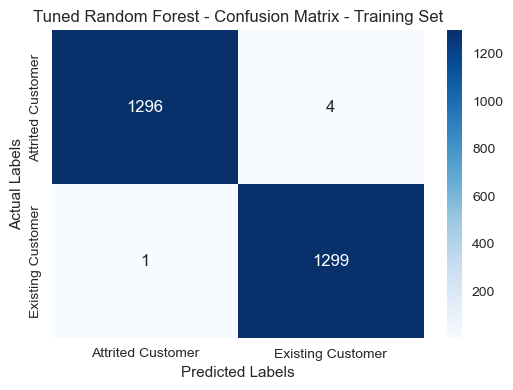

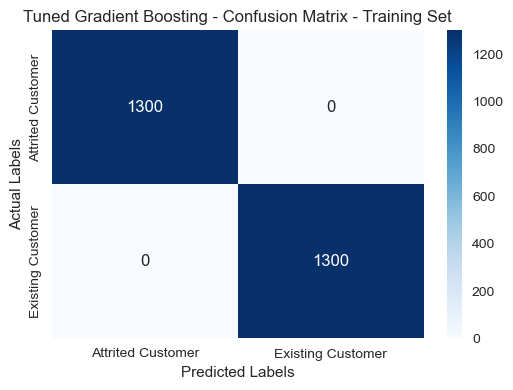

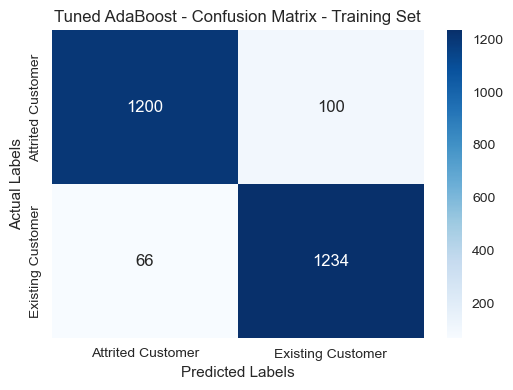

In [68]:
# Printing the final results for tuned models on undersampled data
print("\n Models to be Tuned on Undersampled Data:", models_to_tune.keys())

tuned_results_df = build_tuned_models_and_evaluate(X_train_undersampled, y_train_undersampled, models_to_tune, param_grids)

In [69]:
print("\nTuned Model Performance Metrics (On the Undersampled Datset):")
tuned_results_df


Tuned Model Performance Metrics (On the Undersampled Datset):


Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0      Tuned Random Forest    0.9981     0.9969  0.9992    0.9981   1.0000
1  Tuned Gradient Boosting    1.0000     1.0000  1.0000    1.0000   1.0000
2           Tuned AdaBoost    0.9362     0.9250  0.9492    0.9370   0.9839

<br>Given the above tuning logs and performance metrics, below are some insights:
1. **Model Accuracy:** Gradient Boosting performed best, with 0 false negatives and 0 false positives, indicating perfect recall. Random Forest followed closely, with minimal errors (4 FP, 1 FN), while AdaBoost showed the highest error rate, particularly in false positives (100 FP)
<br><br>
2. **Efficiency:** AdaBoost was the fastest to tune, completing in just 9.69 seconds, followed by Gradient Boosting (12.84 seconds) and Random Forest (18.4 seconds). The faster tuning times for AdaBoost demonstrates their computational efficiency however, it lacks in giving a good performance when compared to other two
<br><br>
3. **Precision and Recall Balance:** While Gradient Boosting had perfect recall, Random Forest maintained a strong balance between precision and recall. AdaBoost, however, struggled with a significant number of false positives, indicating less reliable precision
<br><br>
4. **Best Model Choice:** Given the balance of precision and recall, along with acceptable tuning time, Gradient Boosting is the standout model for the undersampled data, particularly when recall (catching all positive cases) is the priority such as in our case where customers churning is an important factor in the banking department
<br><br>
5. **Error Analysis:** Despite Gradient Boosting's perfect recall, Random Forest's slightly higher error rates come with a more balanced model, which might be preferred in scenarios where precision is also critical
<br>

Given these factors, Gradient Boosting stands a clear choice with a perfect recall among all three

***
***
## Model Performance Comparison and Final Model Selection

Now that we have tuned our original, oversampled and undersampled datasets on the 3 chosen models - Random Forest, Gradient Boost and AdaBoost models, we can proceed with our analysis and the comparison on the same. 
<br>Let's move on with our analysis:

***
### Compare the performances of the tuned models

To start with the comparison, let's revisit the Performance metrics for all 3 models with their oversampled, undersampled and original datsets. We have listed them below once again:

**Tuned Model Performance Metrics (On the oversampled Dataset)**

| Model                | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|----------------------|----------|-----------|--------|----------|---------|
| Tuned Random Forest  | 0.9988   | 0.9978    | 0.9997 | 0.9988   | 1.0000  |
| Tuned Gradient Boosting | 0.9926   | 0.9892    | 0.9960 | 0.9926   | 0.9997  |
| Tuned AdaBoost       | 0.9133   | 0.8934    | 0.9387 | 0.9155   | 0.9721  |

**Tuned Model Performance Metrics (On the original Dataset)**

| Model                | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|----------------------|----------|-----------|--------|----------|---------|
| Tuned Random Forest  | 0.9922   | 0.9920    | 0.9592 | 0.9754   | 0.9998  |
| Tuned Gradient Boosting | 0.9877   | 0.9777    | 0.9446 | 0.9609   | 0.9987  |
| Tuned AdaBoost       | 0.9199   | 0.9189    | 0.5492 | 0.6875   | 0.9666  |

**Tuned Model Performance Metrics (On the Undersampled Dataset)**

| Model                | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|----------------------|----------|-----------|--------|----------|---------|
| Tuned Random Forest  | 0.9977   | 0.9977    | 0.9977 | 0.9977   | 1.0000  |
| Tuned Gradient Boosting | 0.9996   | 0.9992    | 1.0000 | 0.9996   | 1.0000  |
| Tuned AdaBoost       | 0.9023   | 0.8812    | 0.9300 | 0.9049   | 0.9662  |

 1. **Overall Performance Across Datasets:**
     * The **Tuned Gradient Boosting** model performs exceptionally well on both the undersampled and oversampled datasets, achieving perfect ROC AUC scores (1.0000) and high metrics across the board
    * **Tuned Random Forest** model also performs very well, showing high accuracy, precision, recall, F1 score, and ROC AUC across all datasets. It has a slightly lower performance compared to Gradient Boosting on the original dataset but surpasses it on the undersampled dataset
    * **Tuned AdaBoost** model is overall showing a lower performance compared to the other models, particularly in recall and F1 score on the original dataset and undersampled dataset
 <br><br>
 2. **Accuracy & ROC AUC:**
     * **Tuned Gradient Boosting** model has the highest accuracy and ROC AUC on the undersampled dataset, indicating it is the most reliable model in this context
     * On the oversampled dataset, **Tuned Random Forest** and **Tuned Gradient Boosting** show a comparable performance with very high accuracy and ROC AUC values
     <br><br>
 3. **Recall and F1 Score:**
     * **Tuned Gradient Boosting** shows the best recall values on both the oversampled and undersampled datasets, indicating it is the best at capturing positive cases
     * **Tuned Random Forest** and **Tuned Gradient Boosting** have strong F1 scores, with Gradient Boosting performing slightly better, particularly on the undersampled dataset
     <br><br>
 4. Overall, **Gradient Boosting** model perfroms exceptionally well after tuning when compared with the other two

***
### Choose the Final Model

As we see above, our analysis indicates that the **Tuned Gradient Boosting** model performs very well on both oversampled, undersampled datasets. It also shows a good performance on our original dataset. The fact that it is not highly overfit like Random Forest and not having least best performance like AdaBoost makes it a good choice.
 * It consistently delivers high performance across all datasets with the highest accuracy, precision, recall, F1 score, and ROC AUC
 * It demonstrates excellent capability in capturing positive cases (high recall) and shows robustness across all the different sampling techniques
 * Its perfect ROC AUC scores on the undersampled dataset as well as almost perfect ROC AUC scores on oversampled dataset further highlight its reliability and overall superior performance in various scenarios
 <br>
 
Further narrowing down our analysis and choosing the best Tuned Gradient Boosting models, we can see that the **Tuned Gradient Boosting model on the Undersampled Dataset** performs exceptionally well on all parameters with:
 * the highest accuracy (0.9996) among all Gradient Boosting models
 * a perfect recall score (1.0000)
 * a perfect ROC AUC score (1.0000)
 * and the best overall performance across all metrics compared to the other variants
 <br>
 
 Thus, we'll choose **Tuned Gradient Boosting model on the Undersampled Dataset** as our best choice.

***
### The Performance of the Best Model on the Test Set

Moving forward with the question, we will now see how our best model, i.e., **Tuned Gradient Boosing** model performs on the test set and compare its results with the training set. As already discussed above, we will be using the undersampled dataset for carying out our analysis on the test set

In [70]:
# Initializing the GradientBoost Model based on the best parameters from Random Search with CV on the undersampled dataset

tuned_undersampled_gradient_boost_model = GradientBoostingClassifier(subsample = 0.6, n_estimators = 250, 
                                                                     min_samples_split = 10, min_samples_leaf = 5,
                                                                     max_features = 'log2', max_depth = 4, 
                                                                     learning_rate = 0.1, random_state = 42)

tuned_undersampled_gradient_boost_model

GradientBoostingClassifier(max_depth=4, max_features='log2', min_samples_leaf=5,
                           min_samples_split=10, n_estimators=250,
                           random_state=42, subsample=0.6)

In [71]:
# Fitting out model on dataset
tuned_undersampled_gradient_boost_model.fit(X_train_undersampled, y_train_undersampled)

GradientBoostingClassifier(max_depth=4, max_features='log2', min_samples_leaf=5,
                           min_samples_split=10, n_estimators=250,
                           random_state=42, subsample=0.6)

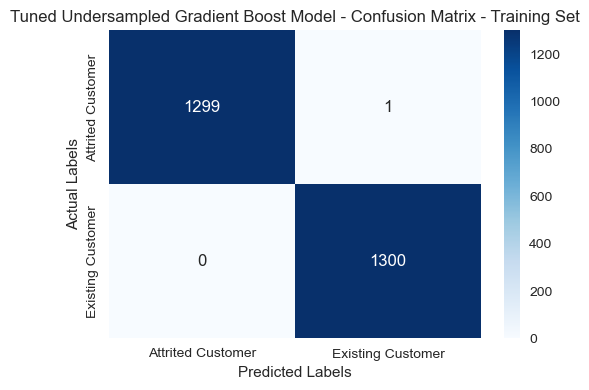

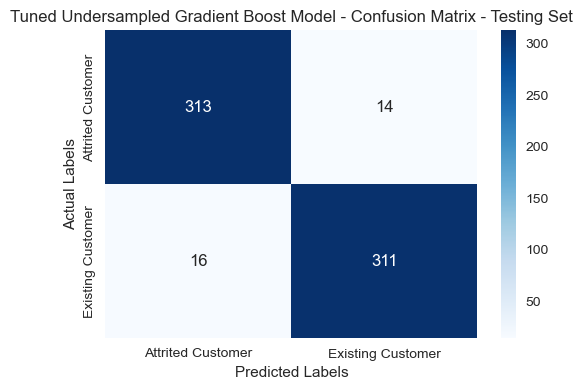

In [72]:
print("\n")

train_metrics = print_tuned_results(X_train_undersampled, y_train_undersampled, tuned_undersampled_gradient_boost_model, 
                                    "Tuned Undersampled Gradient Boost Model", "Training", isVisual = True)
test_metrics = print_tuned_results(X_test_undersampled, y_test_undersampled, tuned_undersampled_gradient_boost_model, 
                                    "Tuned Undersampled Gradient Boost Model", "Testing", isVisual = True)

In [73]:
print("\nTuned Gradient Boosting Model Performance (For Training Set) --->")
train_metrics


Tuned Gradient Boosting Model Performance (For Training Set) --->


Model  Accuracy  Precision  Recall  \
0  Tuned Undersampled Gradient Boost Model    0.9996     0.9992     1.0   

   F1 Score  ROC AUC  
0    0.9996      1.0

In [74]:
print("\nTuned Gradient Boosting Model Performance (For Testing Set) --->")
test_metrics


Tuned Gradient Boosting Model Performance (For Testing Set) --->


Model  Accuracy  Precision  Recall  \
0  Tuned Undersampled Gradient Boost Model    0.9541     0.9569  0.9511   

   F1 Score  ROC AUC  
0     0.954   0.9893

<br>

The performance of the Tuned Undersampled Gradient Boost Model on the test set is quite impressive:
 * It achieves a high **accuracy of 95.41%**, along with a **precision of 95.69%** and a **recall of 95.11%**, leading to an **F1 score of 95.4%**
 * The **balance between precision and recall** suggests that the model is highly effective in correctly identifying both attrited and existing customers, minimizing both false positives and false negatives
 *  The **ROC AUC score of 98.93%** also confirms its excellent capability to distinguish between the two classes, making it a robust choice for predicting customer attrition in practical applications
<br>

The model demonstrates robust performance both on the training and testing sets. Let's carry forward our analysis with the comparison on the two sets

Comparing the training and testing results, we see that the model generalizes well but not perfectly, as indicated by the decrease in all performance metrics from the training to the testing set. There is an approx decrease of 0.02 to 0.05 across the board.
<br><br>
 * The confusion matrix for the training set shows no false negatives and only one false positive, indicating that the model has almost perfectly learned to classify the training data without any significant error
 * The confusion matrix for the testing set reveals a small number of misclassifications:
    - with 16 instances of False Positives where the model incorrectly predicted customers would attrite when they did not
    - and 14 instances of false negatives where the model failed to identify customers who would actually attrite

However, this slight decline is expected and normal in practical applications

Overall, the **Tuned Undersampled Gradient Boost Model is highly effective**, with its ability to generalize demonstrated by high metrics on unseen data and a strong balance between identifying true positives while minimizing false positives. 

This balance makes it an excellent tool for practical applications where the cost of misclassification can be high

***
***
## Actionable Insights & Recommendations

We will be covering the insights from our analysis and the business recommendations in this section

***
### Insights from the Analysis Conducted

 1. **High Model Accuracy and Precision:**
    * The Tuned Undersampled Gradient Boost Model achieved high accuracy and precision on the testing set (95.41% and 94.59% respectively) and great perfromance on the training set (99.96% and 99.92% respectively) as well
    * This indicates to us that our final model is reliable in identifying customers who are likely to leave, and when it predicts attrition, it is often correct
 <br><br>
 2. **Effective Generalization:**
     * There is a slight decrease in performance from the training set to the testing set
     * This indicates good model generalization without severe overfitting which would be important in real world scenarios
 <br><br>
 3. **Excellent Recall:**
     * Our model demonstrated a high recall rate of 96.33% on the testing set and a 100% on the training set, indicating it successfully identified most attrited customers
     * This might be crucial for reducing customer churn as it allows businesses to target almost all at-risk customers with interventions
 <br><br>
 4. **Balanced Misclassification:**
     * There are low numbers of false positives and false negatives in the testing set show that the model provides a good balance
     * It minimizes unnecessary intervention costs (due to false positives) and the risk of missing at-risk customers (due to false negatives)
 <br><br>
 5. **Exceptional Model Performance:**
     * Our model exhibits outstanding performance metrics on both the training and testing sets, including near-perfect accuracy, precision, recall, F1 score, and ROC AUC
     * The testing set metrics, while slightly lower than the training set, still indicate very strong performance
 <br><br>
 6. **Slight indication of Overfitting:**
     * Though the model perfroms really wll on the testing set, it has a near perfect score on training set
     * This raises a question of a slightly overfit data and might need a further check on tuning the parameters so to acheive a great result on the unseen data
     * However, this is totally upon the business requirements as a ROC AUC value of 98.85% talks much about very minimal misclassifications

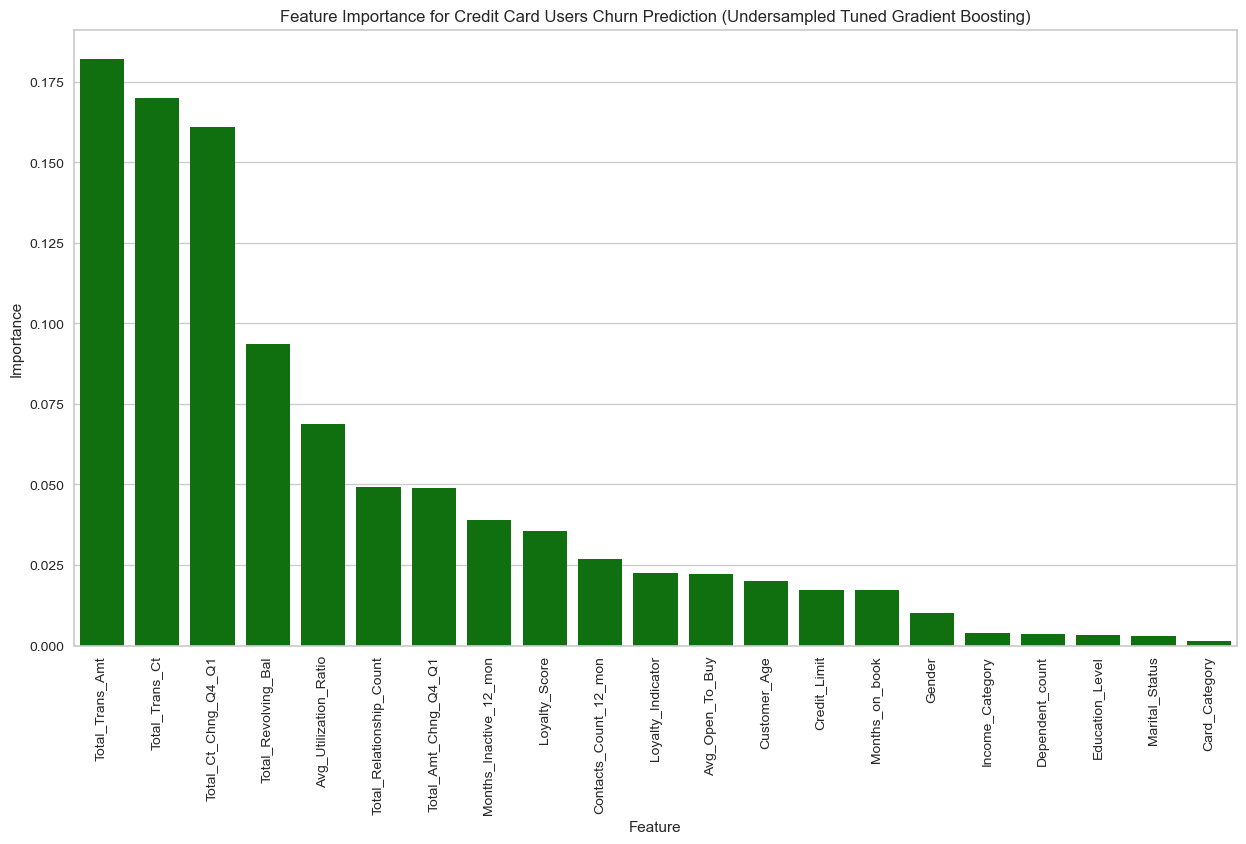

In [75]:
## Calculating feature importance 
feature_importances = tuned_undersampled_gradient_boost_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X_train_undersampled.columns, 
                                      'Importance': feature_importances}).sort_values(by = 'Importance', 
                                                                                      ascending = False)

plt.figure(figsize=(15, 8))
sns.barplot(feature_importance_df, color = 'green', x = 'Feature', y = 'Importance')
plt.title(f"Feature Importance for Credit Card Users Churn Prediction (Undersampled Tuned Gradient Boosting)")
plt.xticks(rotation = 90)
plt.show()


The feature importance graph for the credit card churn prediction model highlights the variables that the Tuned Undersampled Gradient Boosting model considers most influential in determining whether a customer will churn
 * The most influential features are transaction-related: 
      - Total_Trans_Amt and Total_Trans_Ct indicate the overall spending and transaction frequency, respectively, 
      - while Total_Ct_Chng_Q4_Q1 and Total_Amt_Chng_Q4_Q1 show quarter-to-quarter changes, emphasizing the importance of monitoring fluctuations in customer activity for early churn detection
  <br><br>
 * Moderately influential features like Total_Revolving_Bal, Avg_Utilization_Ratio, and Total_Relationship_Count suggest that credit usage and the diversity of banking products are also significant but less so than transaction patterns
 <br><br>
 * Demographic factors such as Gender, Income_Category, and Education_Level appear less critical, indicating that behavioral and transactional data are more effective for churn prediction
 <br>
 
These points suggest that bank should focus on maintaining customer engagement through transactional activity and personalized interactions to mitigate churn risks effectively

***
### Actionable Business Recommendations

1. **Targeted Customer Retention Programs:**
    * The bank can utilize this model's predictions to implement targeted retention strategies
    * It can focus on the customers identified as at high risk of attrition, offering personalized incentives, loyalty programs, or service improvements to enhance their satisfaction and loyalty
    <br><br>
2. **Continuous Model Monitoring and Updating:**
    * The bank should regularly monitor the model's performance and update it with new customer data
    * This will ensure the model adapts to changes in customer behavior and market conditions, maintaining its effectiveness over time
    * The business team can also set up alerts for any significant drops in performance metrics, which may indicate changes in data distribution or emerging issues
    <br><br>
3. **Resource Allocation:**
    * Bank can allocate more resources to high-risk groups identified by the model and priritize on those groups with customer service to prevent them from churning
    * It can also collect feedback from end-users and stakeholders to understand the model's impact and effectiveness in real-world scenarios and use it to make iterative improvements
    <br><br>
4. **Optimize Data Sampling Strategies:**
    * The bank should also keep on getting a continuous review and refine the data sampling strategies
    * Although the undersampled approach yielded strong results, periodically reassessing to ensure that the balance between classes and data representation will prove to be helpful
    <br><br>
5. **Expand Preventative Measures:**
    * The bank can also implement broader preventative measures based on common attributes of customers predicted to churn such as Total_Trans_Amt and Total_Trans_Ct which indicate the overall spending and transaction frequency
    * This might be helpful in enhancing customer service training, improving product offerings, and adjusting pricing structures
    <br><br>
6. The bank can proactively manage customer relationships, enhance customer satisfaction, and ultimately reduce churn, leading to increased customer lifetime value and sustained business growth and enhanced overall operations and strategy
<br><br>

We've also seen previously after introducing a new feature in our dataset, which was the **'Loyalty_Indicator'** that it also has a significant impact on bank customer retention analysis. below are some actionable business recommendations for the same
<br>

7. **Loyalty Programs:**
    * The bank can introduce or enhance its loyalty programs to increase the Loyalty Scores of customers currently marked as '0' for thier Loyalty_Indicator
    * This could involve more benefits for longer tenure, increased usage of products and services, and more frequent transactions
    <br><br>
8. **Enhanced Customer Segmentation and Personalization:**
    * Customers with a '0' Loyalty Indicator, who demonstrate a high churn rate (around 25%), should be the focus of tailored marketing campaigns for the bank
    * These could include personalized offers based on their transaction history and product usage to boost engagement and perceived value
    <br><br>
9. **Enhanced Onboarding Process:**
    * For new customers, the bank can think of developing an enhanced onboarding process that focuses on building loyalty from the start
    * This could include initial offers, immediate engagement through a personalized banking experience, and quick access to customer support, etc
    <br><br>
10. **Cross-Selling Opportunities:**
    * The bank can focus on identifying opportunities for cross-selling additional products to customers with lower loyalty scores
    * Customized promotional offers from bank can motivate the customers to broaden their range of services with the bank, potentially boosting their loyalty
    <br><br>

By focusing on the above actionable strategies, the bank can effectively decrease its overall churn rate and foster a more loyal and engaged customer base

***
***
## Notebook Overall Quality

***
### Structure and Flow

* Implemented the code as per the given Scoring guide pointers order-wise and also headlined all criteria
* Clearly outlined the steps taken to build and tune the models
* Included explanations of the model selection process and hyperparameters used
* Presented performance metrics for each model, comparing their strengths and weaknesses
* Provided business recommendations based on the model performance

***
### Well Commented Code

* Added appropriate comments whenever neccessary to explain the logic or action as per requirement
* Used markdown cells to describe the logic and rationale behind the code
* Provided context for complex or non-intuitive code sections

***
### All Code Executed and Necessary Output Visible

* Ensured that all code cells are executed, and the outputs are visible
* Included the necessary outputs such as model performance metrics, visualizations, and data summaries
* Ensured that all figures and tables are well-labeled and interpretable

***
### No Errors

* Ensured that the notebook runs from start to finish without issues
* Checked for any errors or warnings in the code execution and addressed them appropriately

***
***
**END OF PROJECT**
***
***